### How has the predominant emotional tone changed over time within each genre? 

First lets do a general analysis of how the overall emotional tone had changed over time 

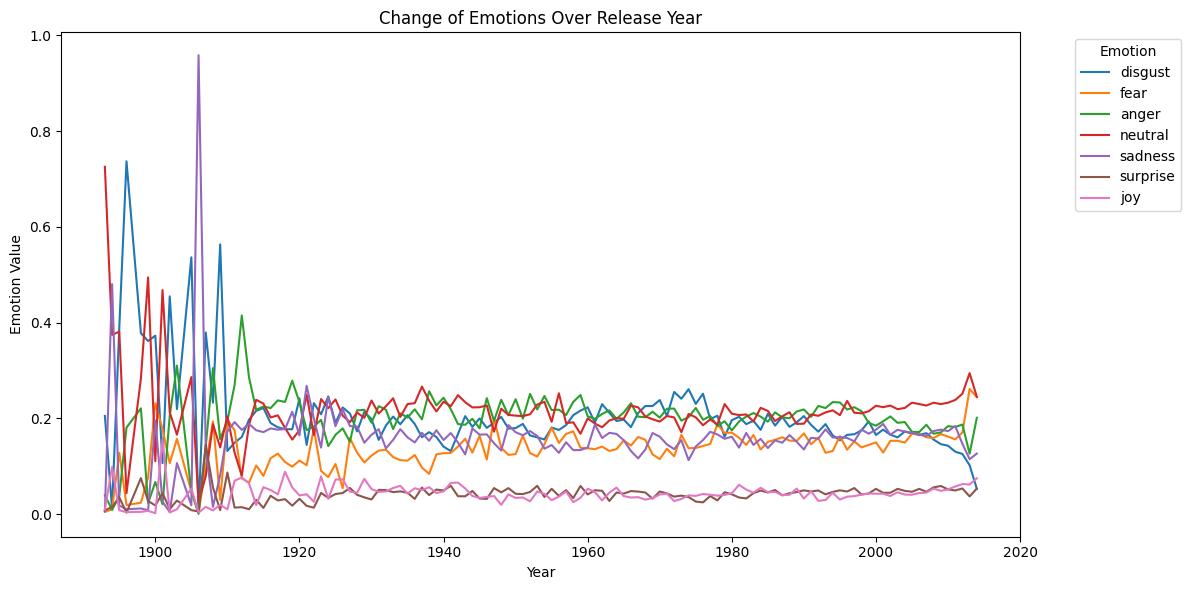

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

sys.path.append("../")
from utils.methods import *

df = pd.read_csv("../../data/final_data_complete.csv")

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)

emotions_df['merge_year'] = emotions_df['merge_year'].astype("Int64")


emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

temp = emotions_df.groupby('merge_year').agg({
    emotion: ['mean'] for emotion in emotions
}).reset_index()


temp.columns = ['merge_year'] + emotions

long_df = pd.melt(temp, id_vars=["merge_year"], 
                  var_name="Emotion", 
                  value_name="Value")

plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df, x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### We can a very high variance in the emotional tone in the film made prior to 1925. This can be attributed to the fact that we have very few films from that era in our dataset and the plot summaries are not enough to get a good idea of the emotional tone of the film.

##### Also we noticed that past 2012 we have very few data point, this scarsity of data, influence the volatility of those emotion and will lead to misleading results

##### So we decided to escude the films made prior to 1925 and after 2012.

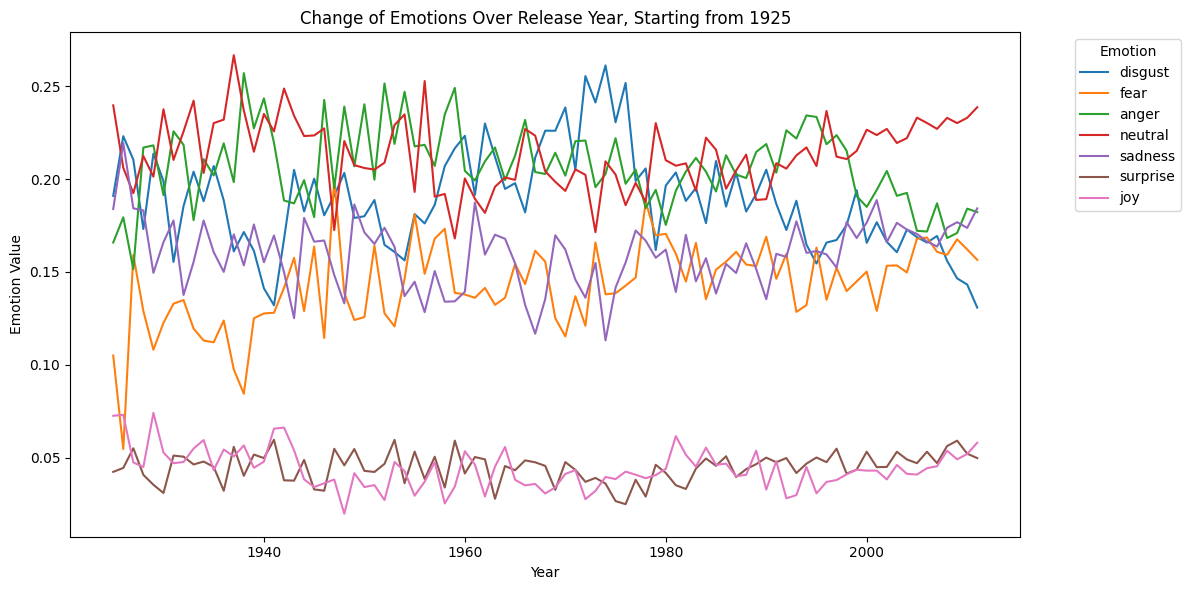

In [2]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=long_df[(long_df['merge_year'] >= 1925) & (long_df['merge_year'] < 2012)], x="merge_year", y="Value", hue="Emotion")
plt.title("Change of Emotions Over Release Year, Starting from 1925")
plt.xlabel("Year")
plt.ylabel("Emotion Value")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



##### Now the plot is way more clear, we can see emotional tones overall seems to be quite stationary over time except few exceptions.

##### Lets go deeper now and see how the predominant emotions have changed over time within each genre.

In [3]:
# Import the dataset from the cleaning part of the Question 1 script
emotions_df = pd.read_csv("../../data/emotions_timeseries.csv")

emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'] 

grouped_df = emotions_df.groupby(['Genres', 'merge_year'])[emotions].mean().reset_index()

genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World cinema": ["sadness", "disgust"]
}

filtered_df = grouped_df[(grouped_df["Genres"].isin(genres_emotions_mapping.keys())) &
                        ((grouped_df["merge_year"] >= 1925) & (grouped_df["merge_year"] < 2012))]
filtered_df[filtered_df['Genres'] == 'World cinema']

,Genres,merge_year,disgust,fear,anger,neutral,sadness,surprise,joy
1423,World cinema,1927.0,0.058494,0.361429,0.454733,0.083778,0.027268,0.011397,0.002901
1424,World cinema,1928.0,0.155387,0.282051,0.448896,0.067146,0.039003,0.002362,0.005156
1425,World cinema,1929.0,0.450881,0.018192,0.059123,0.103908,0.298626,0.055974,0.013297
1426,World cinema,1930.0,0.228029,0.110362,0.269671,0.100799,0.276180,0.010927,0.004030
1427,World cinema,1931.0,0.090704,0.022110,0.343663,0.218374,0.144336,0.089297,0.091517
...,...,...,...,...,...,...,...,...,...
1501,World cinema,2007.0,0.170133,0.158563,0.181986,0.208199,0.181751,0.056520,0.042847
1502,World cinema,2008.0,0.159076,0.122740,0.179165,0.231670,0.196654,0.045741,0.064955
1503,World cinema,2009.0,0.147819,0.161387,0.180398,0.219040,0.193846,0.058199,0.039312
1504,World cinema,2010.0,0.179574,0.146968,0.187775,0.219774,0.152972,0.048458,0.064478


In [4]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = filtered_df[filtered_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_df = genre_dataframes["Action"]
comedy_df = genre_dataframes["Comedy"]
crime_fiction_df = genre_dataframes["Crime Fiction"]
drama_df = genre_dataframes["Drama"]
family_film_df = genre_dataframes["Family Film"]
horror_df = genre_dataframes["Horror"]
indie_df = genre_dataframes["Indie"]
romance_film_df = genre_dataframes["Romance Film"]
thriller_df = genre_dataframes["Thriller"]
world_cinema_df = genre_dataframes["World cinema"]

### Action movies Time Series Analysis

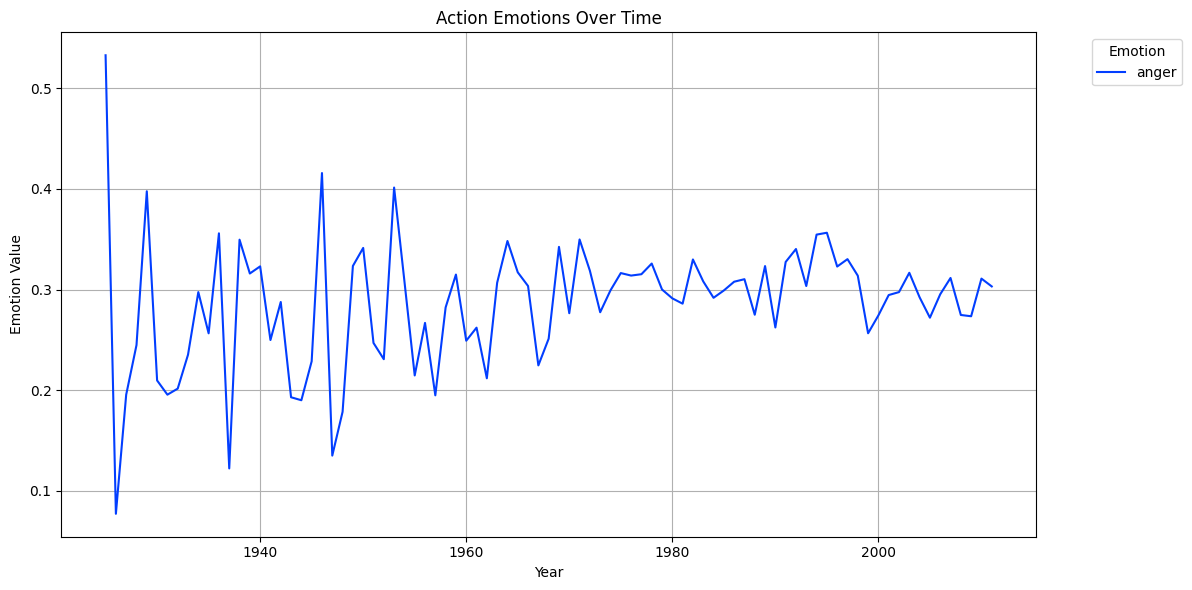

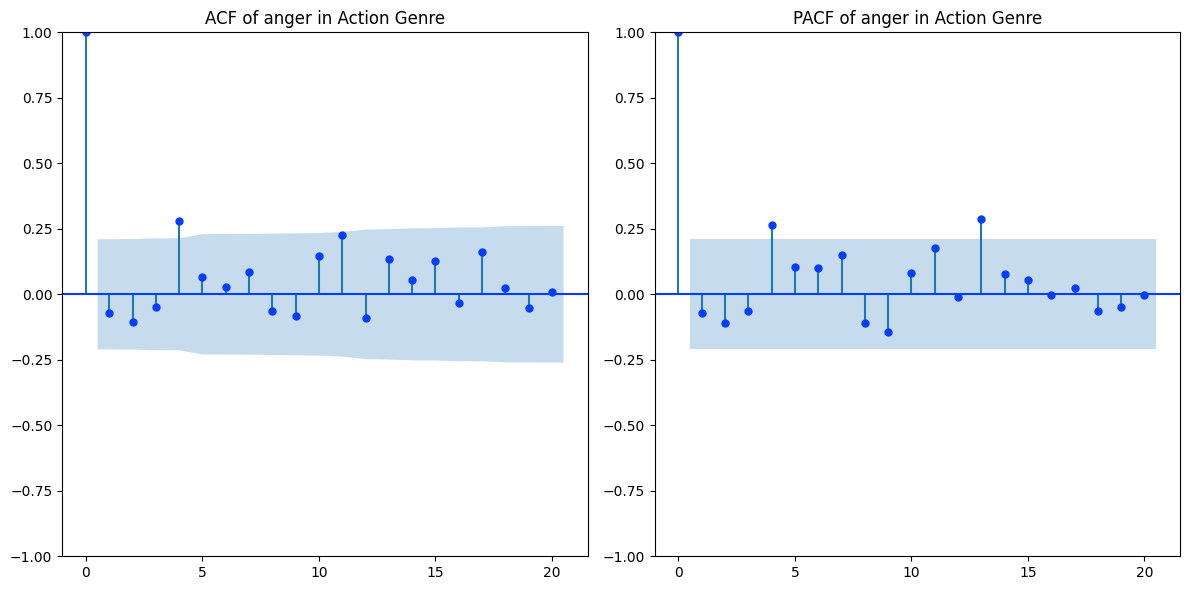

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.78874715330839
p-value: 0.38606255732366246
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 1)


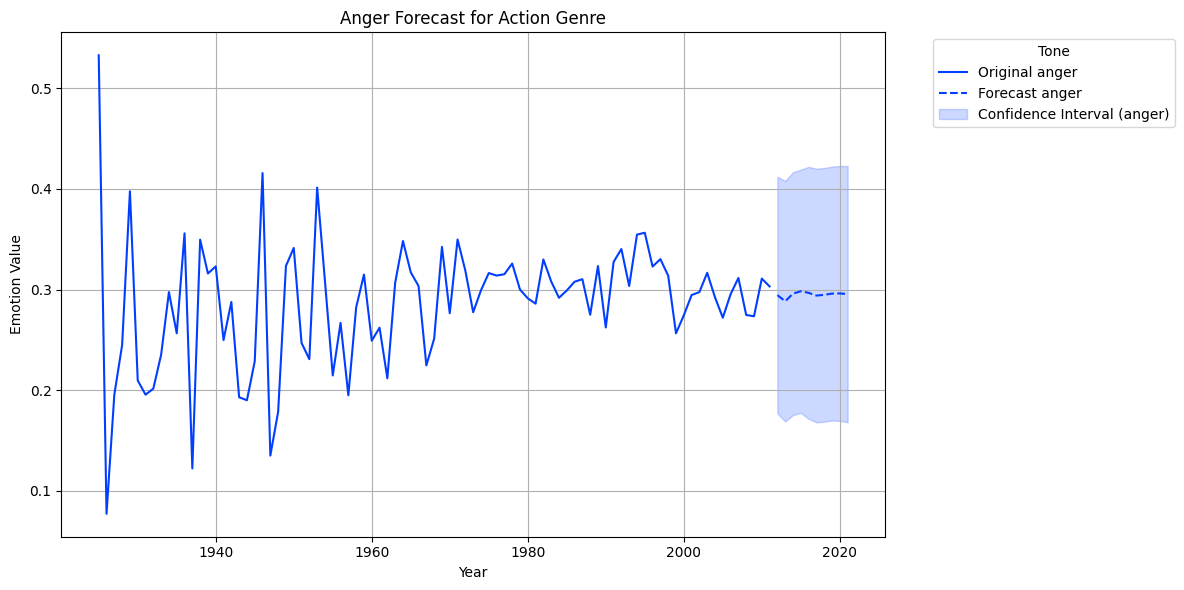

In [5]:

timeseries_plots(action_df, "Action")
action_ts_results = box_jenkins_procedure(action_df, "Action")
action_forecast_df = forecast_series(action_df, "Action", action_ts_results)


### Comedy movies Time Series Analysis

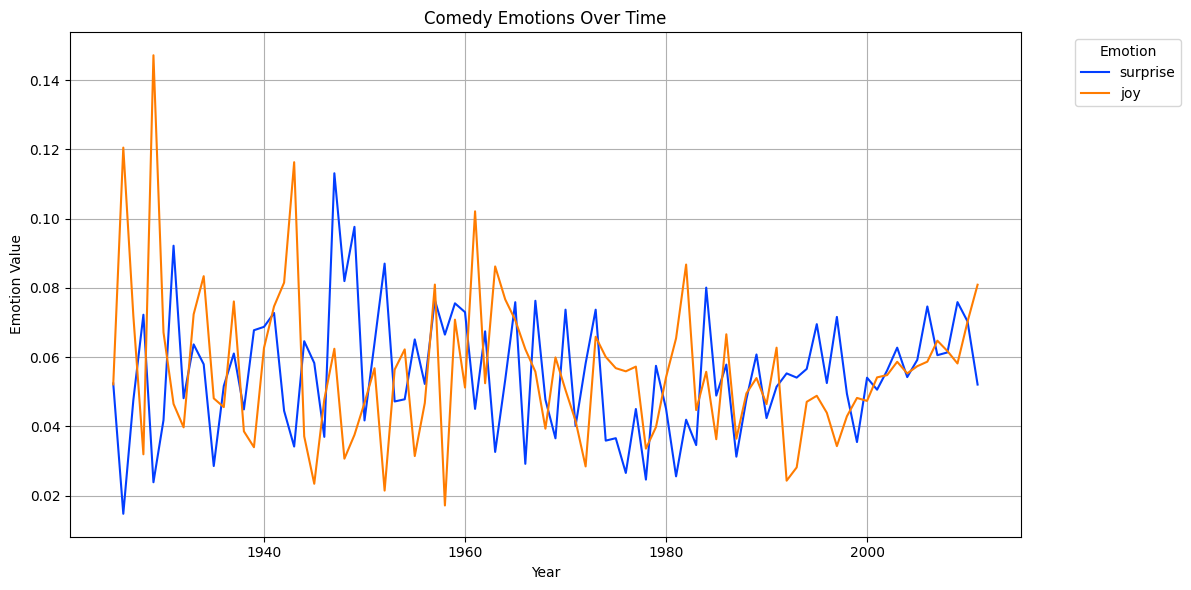

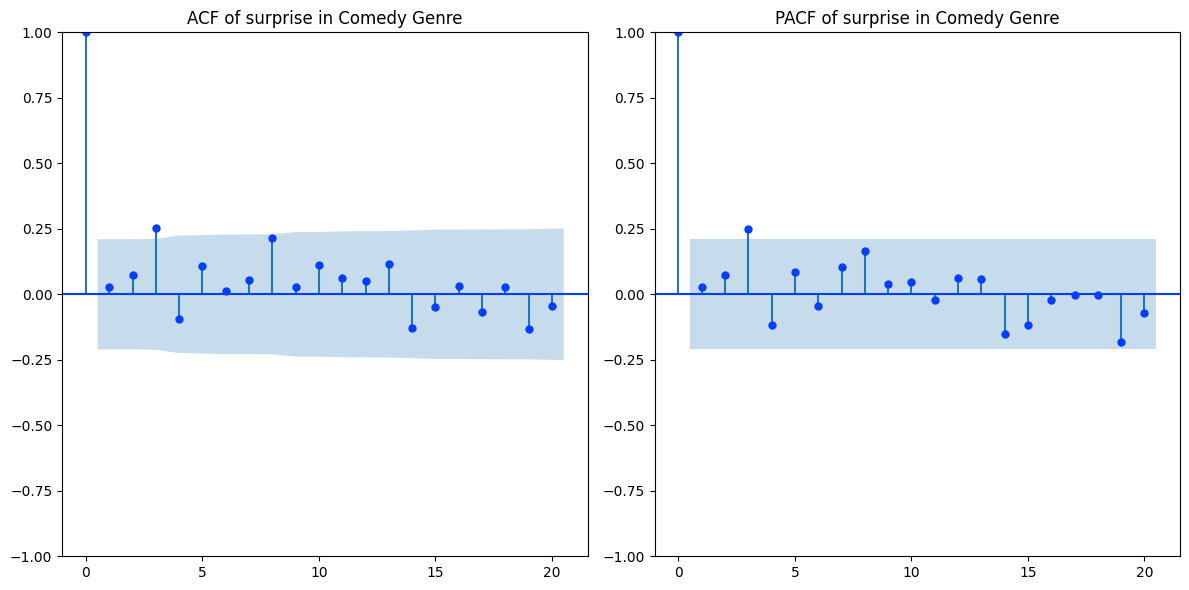

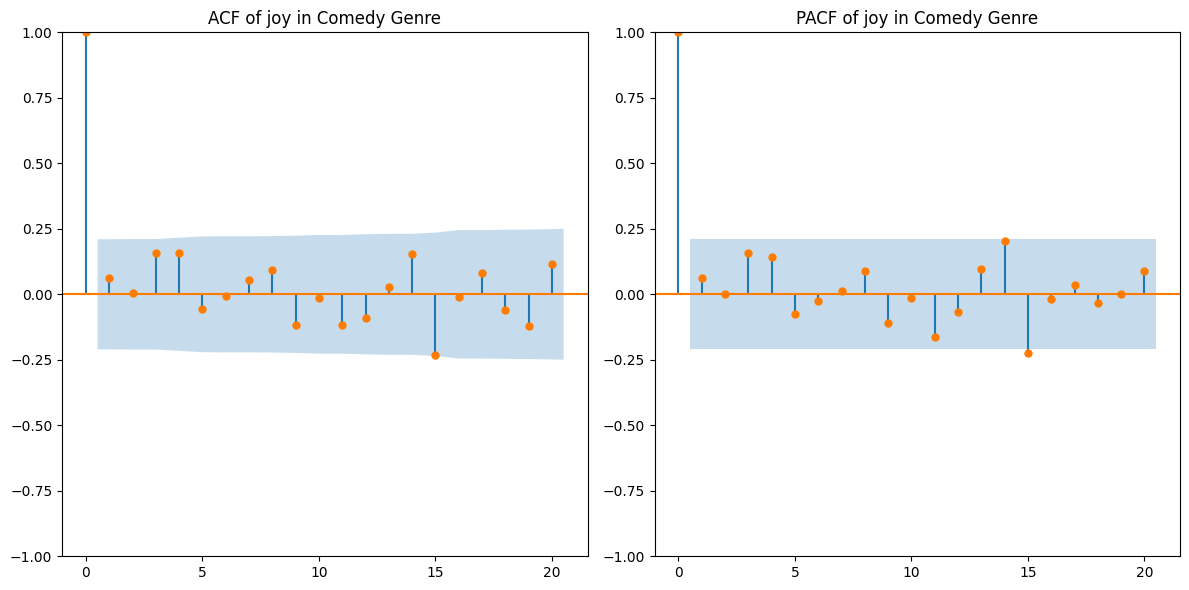

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -3.8855435796210913
p-value: 0.002143852219968141
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.547913514167504
p-value: 9.393303846545818e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


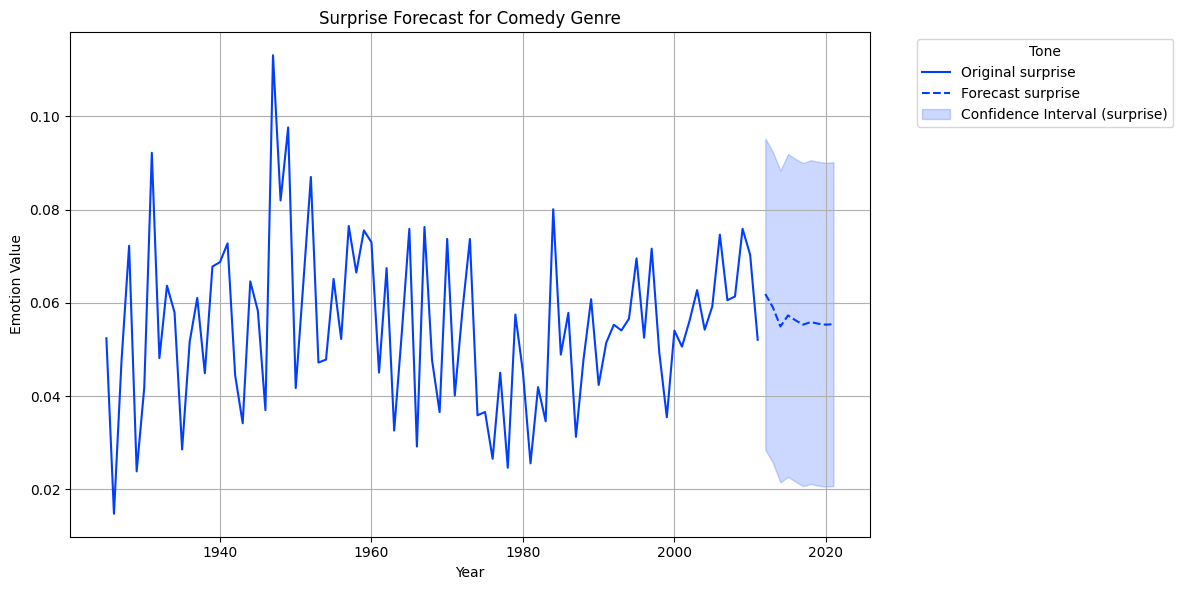

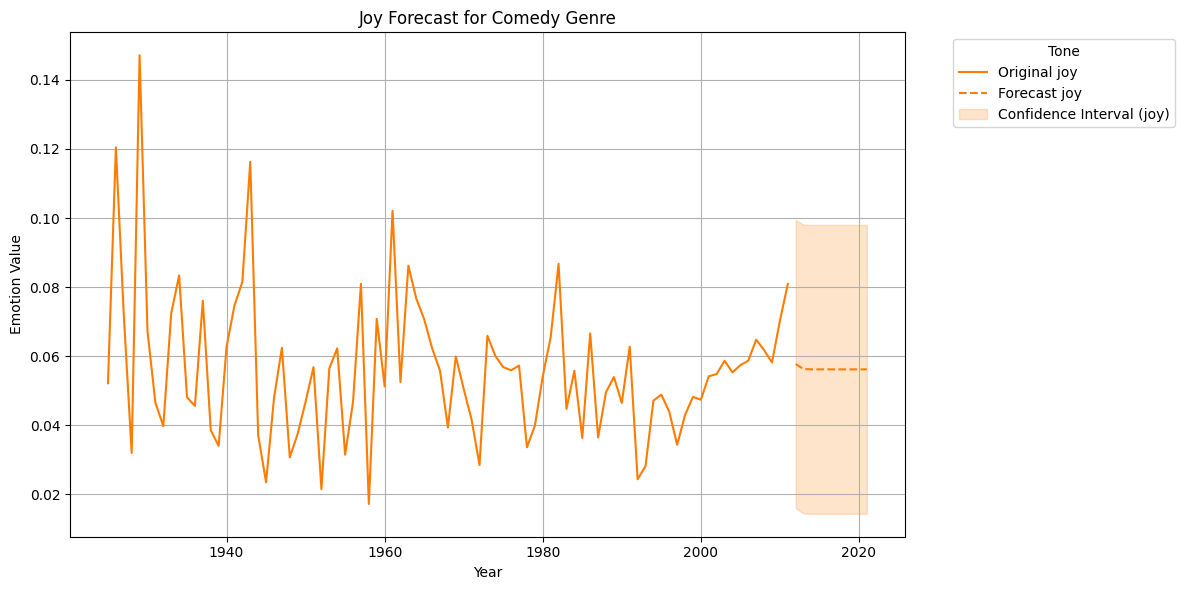

In [6]:
timeseries_plots(comedy_df, "Comedy")
comedy_ts_results = box_jenkins_procedure(comedy_df, "Comedy")
comedy_forecast_df = forecast_series(comedy_df, "Comedy", comedy_ts_results)

### Crime Fiction movies Time Series Analysis

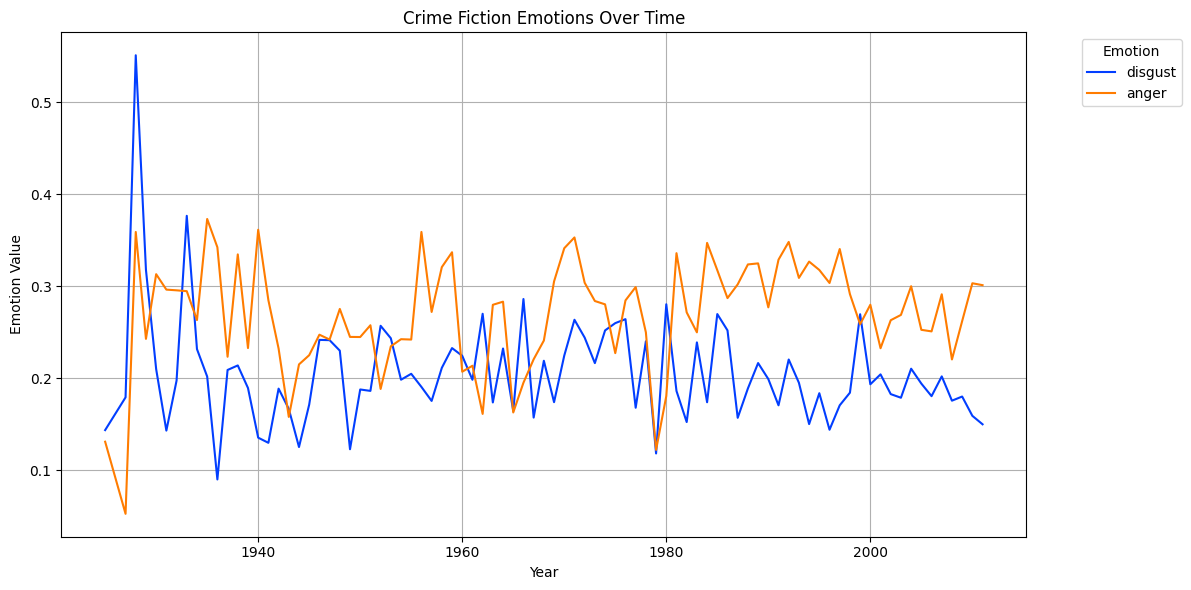

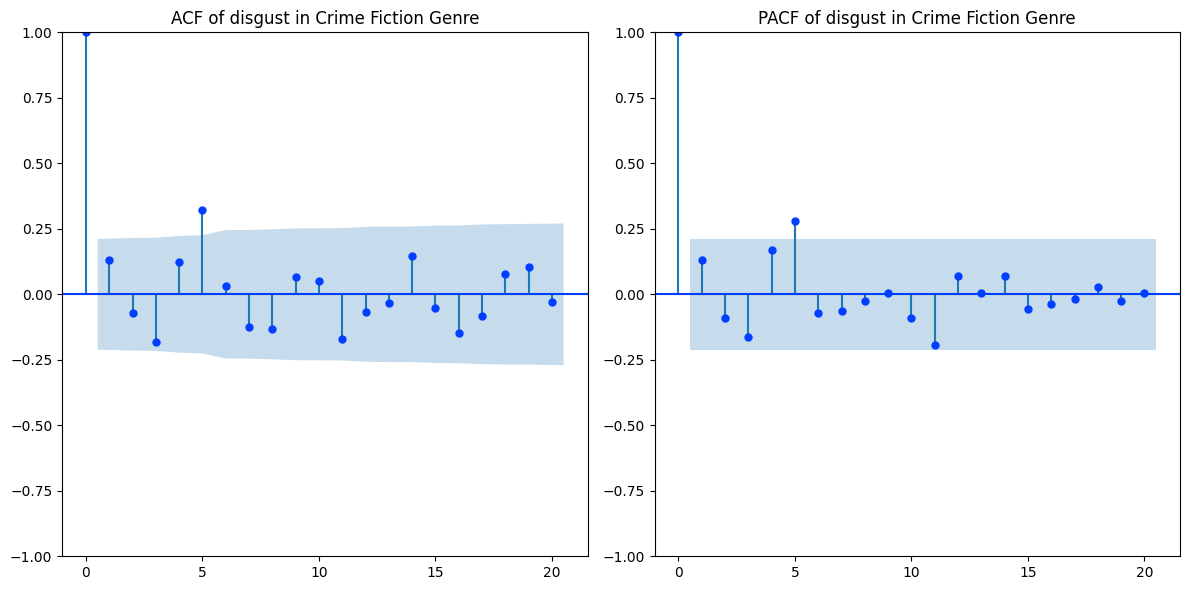

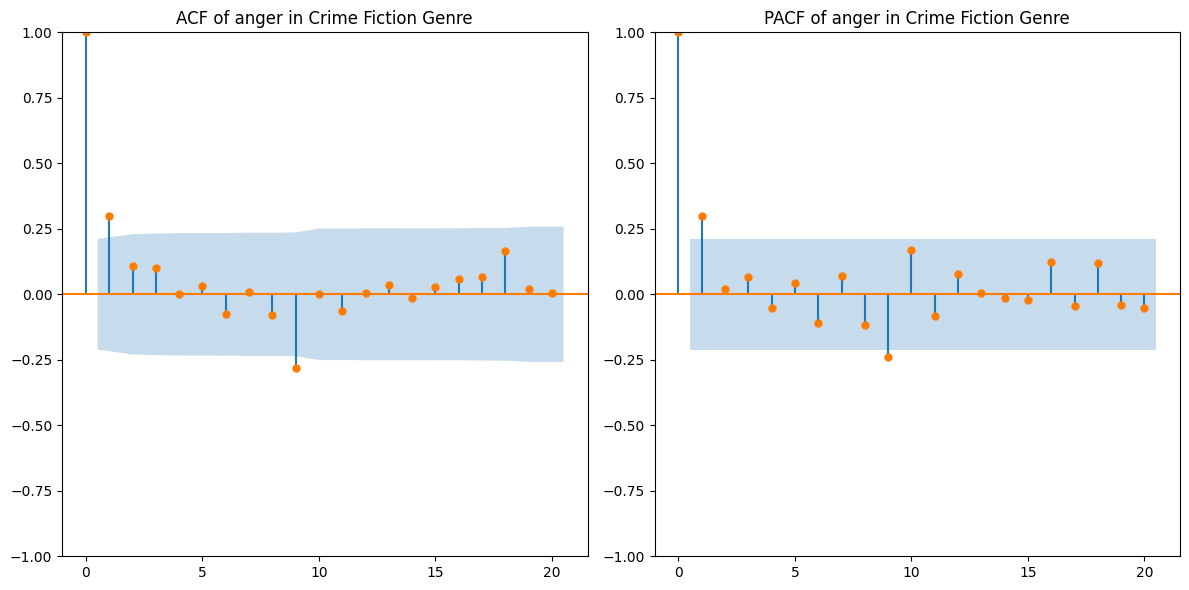

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -6.484593942005353
p-value: 1.2701419125844923e-08
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -6.914634533444469
p-value: 1.1881064710608043e-09
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


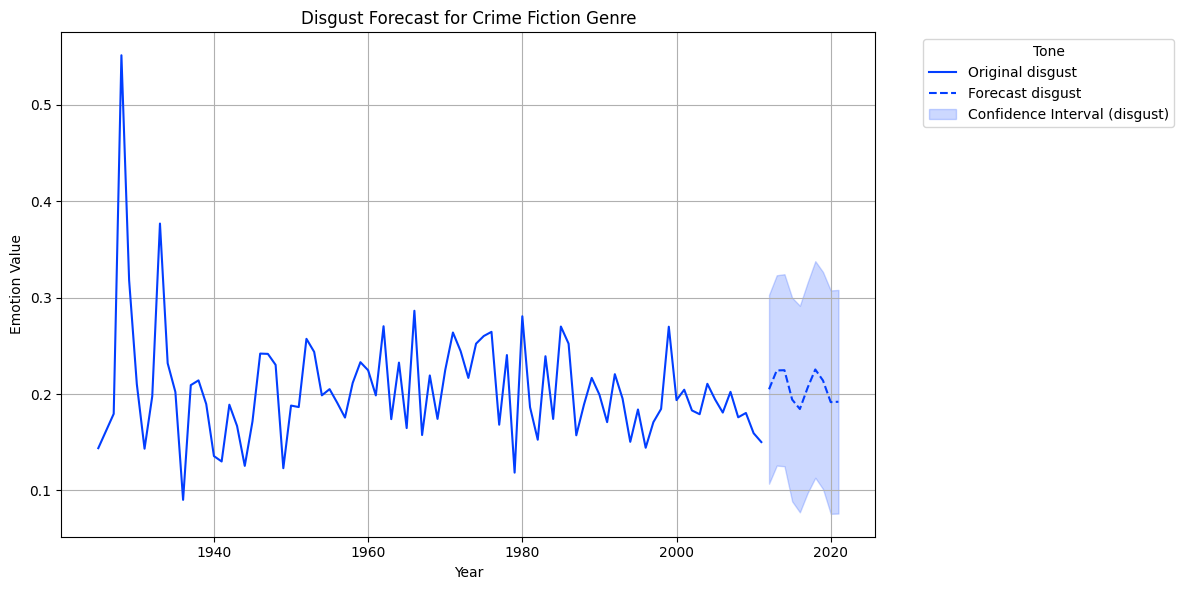

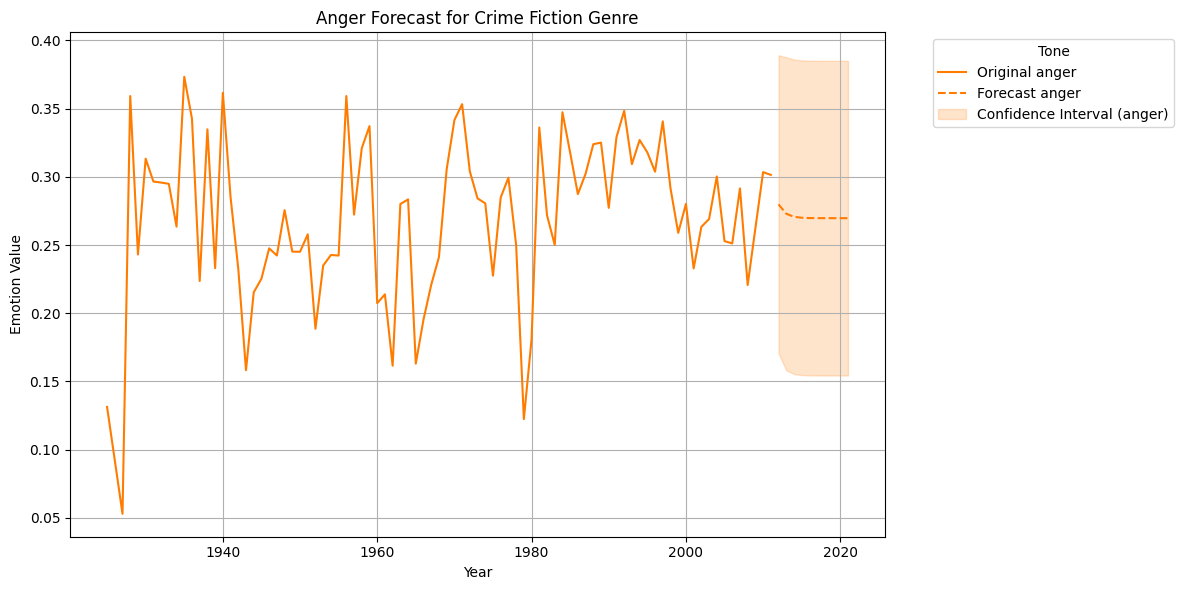

In [7]:
timeseries_plots(crime_fiction_df, "Crime Fiction")
crime_fiction_ts_results = box_jenkins_procedure(crime_fiction_df, "Crime Fiction")
crime_fiction_forecast_df = forecast_series(crime_fiction_df, "Crime Fiction", crime_fiction_ts_results)

## Drama movies Times Series Analysis

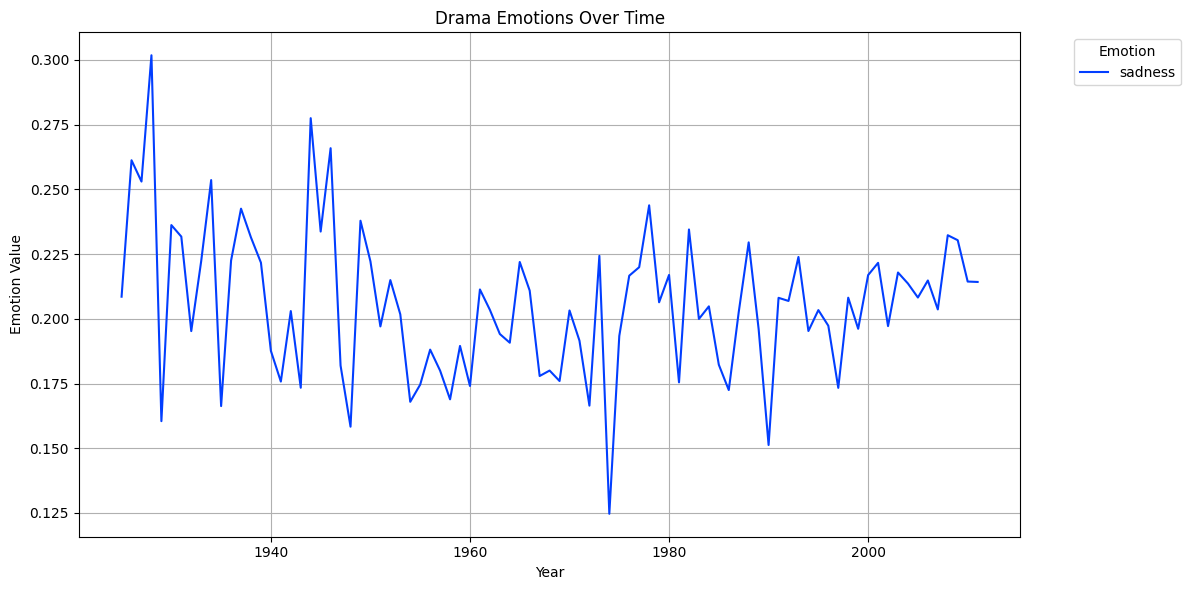

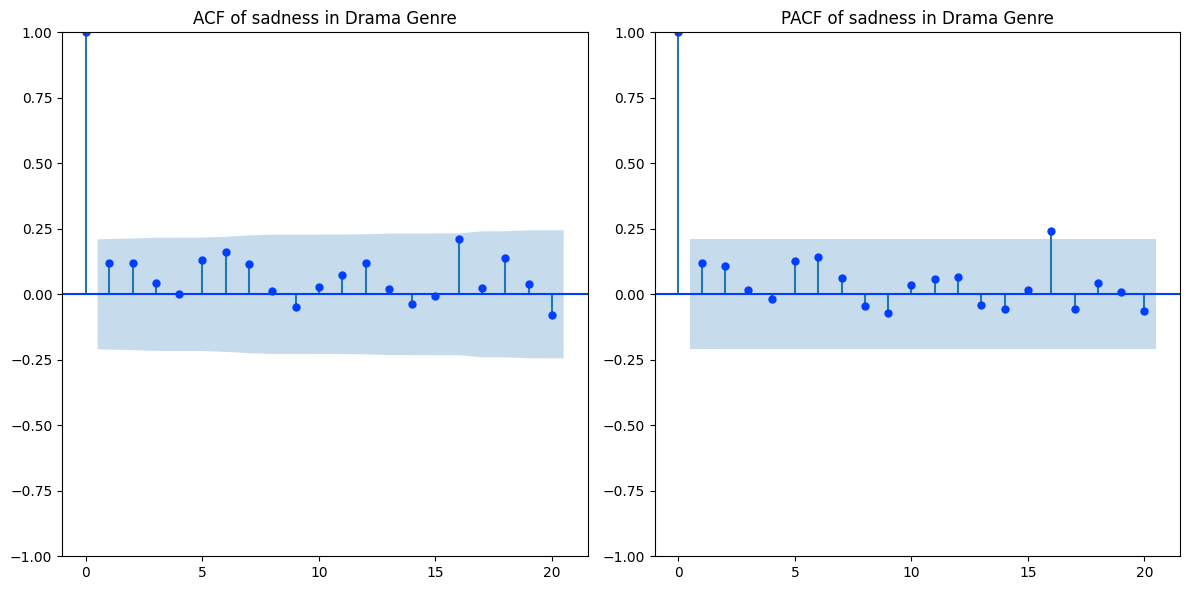

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -8.131424158962503
p-value: 1.0876387226298701e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 1)


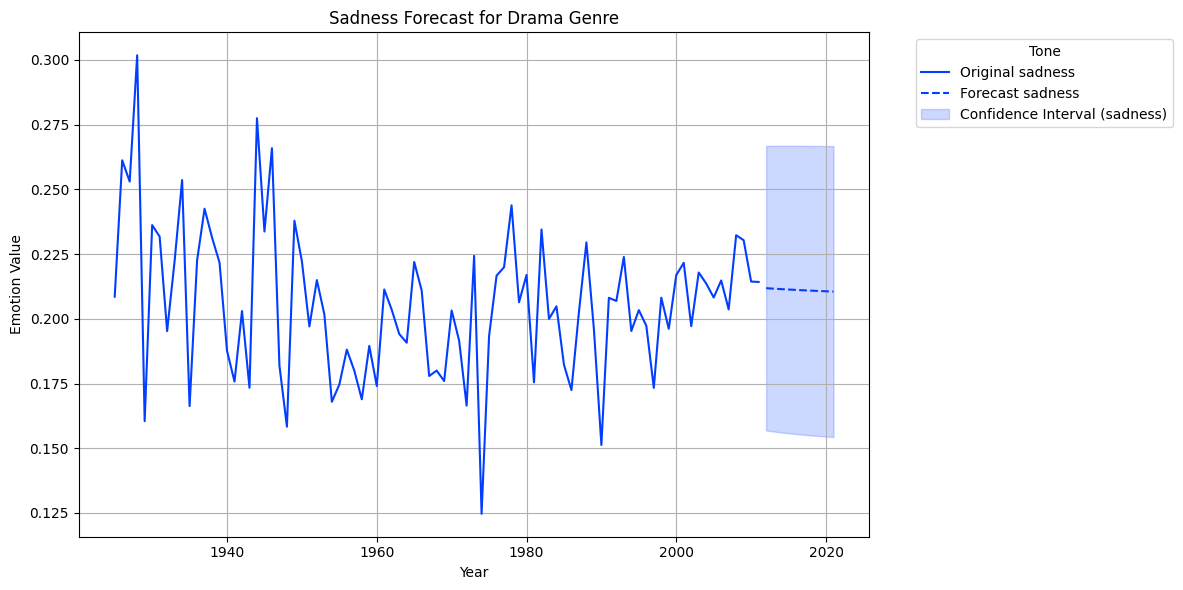

In [8]:
timeseries_plots(drama_df, "Drama")
drama_ts_results = box_jenkins_procedure(drama_df, "Drama")
drama_forecast_df = forecast_series(drama_df, "Drama", drama_ts_results)

## Family Film movies Time Series Analysis

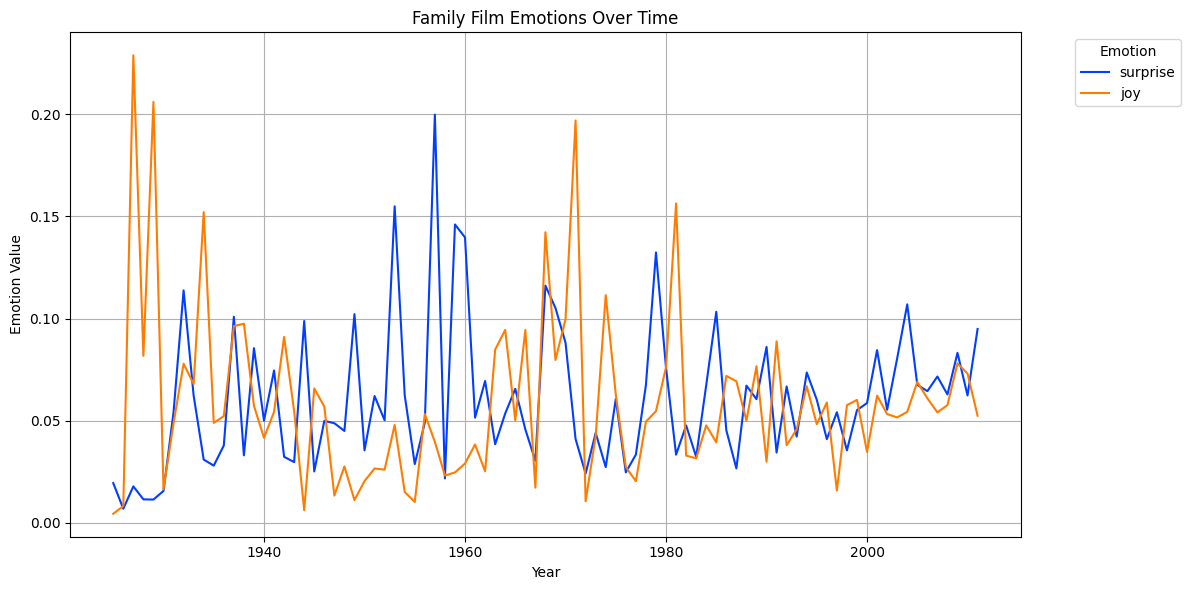

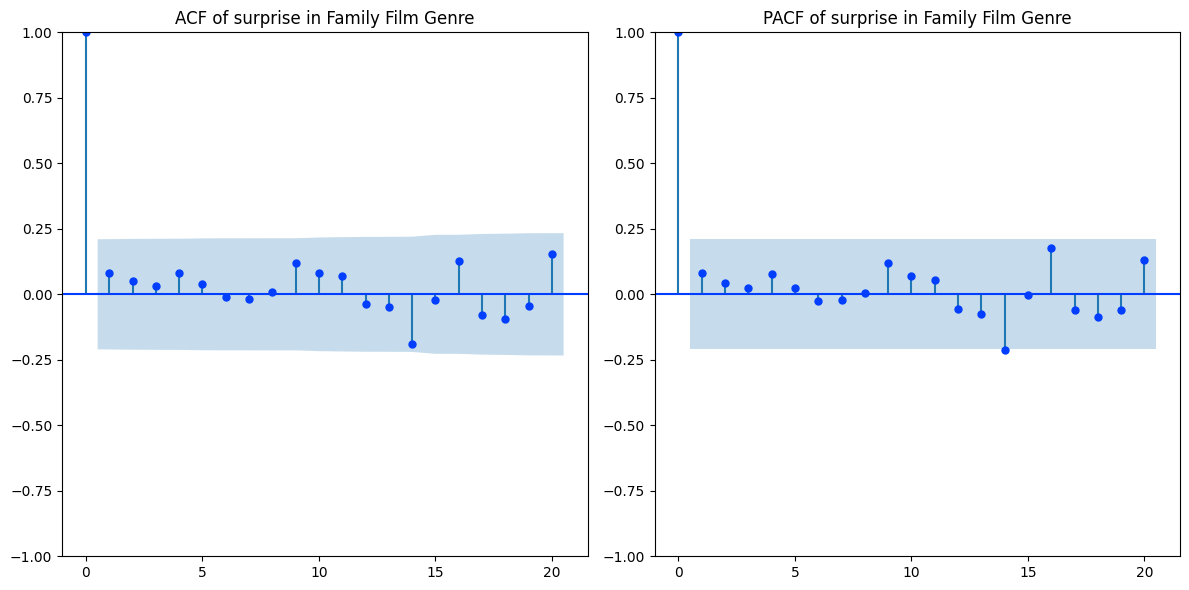

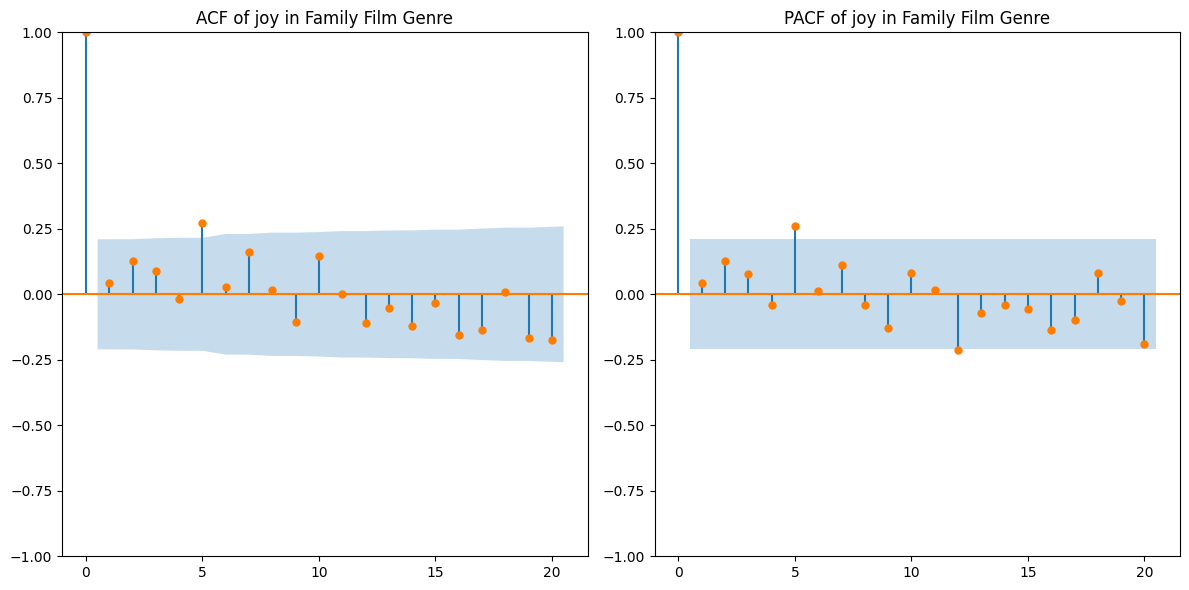

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.473655078539828
p-value: 1.4548682542497265e-13
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.26938964084054
p-value: 0.0005016691687662468
Best ARIMA Order for joy in Family Film Genre: (3, 0, 1)


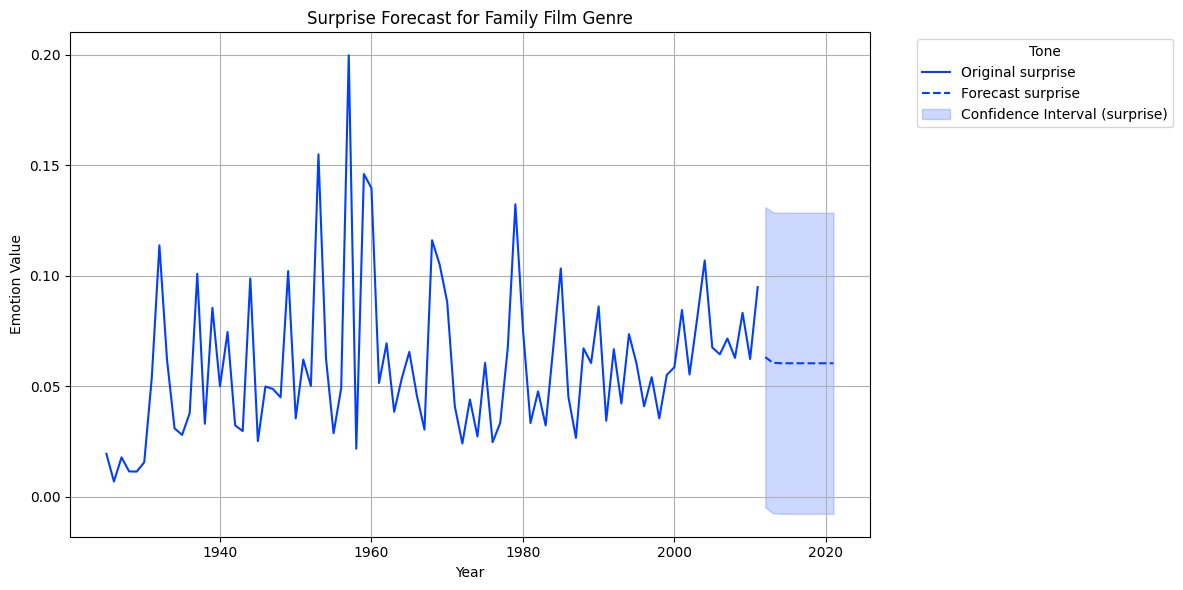

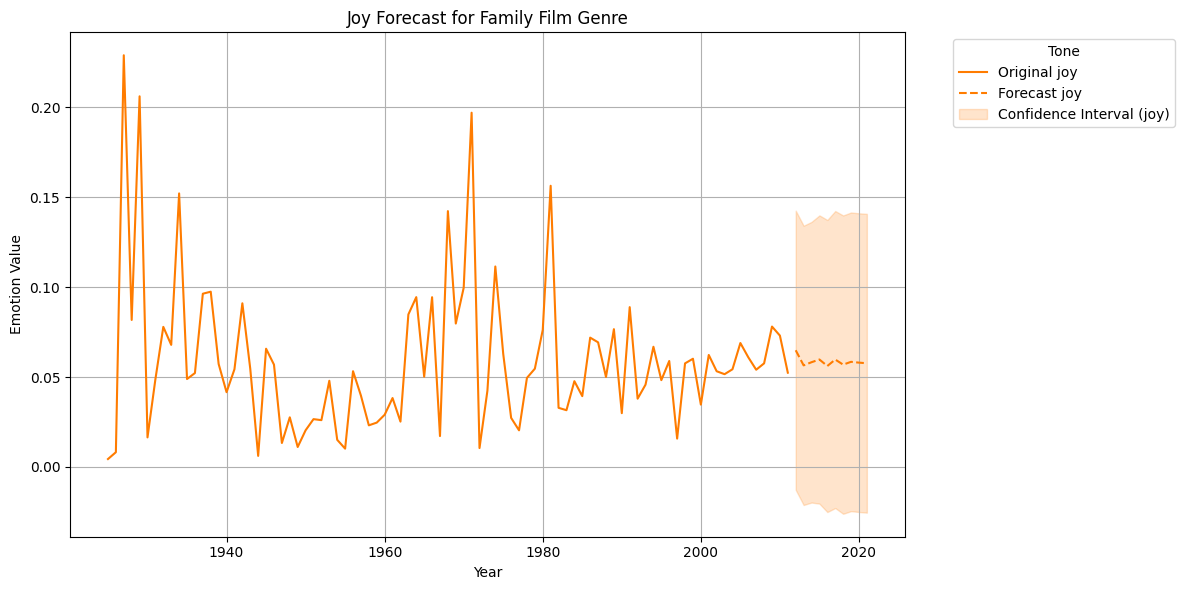

In [9]:
timeseries_plots(family_film_df, "Family Film")
family_ts_results = box_jenkins_procedure(family_film_df, "Family Film")
family_forecast_df = forecast_series(family_film_df, "Family Film", family_ts_results)

## Horror movies Times Series Analysis

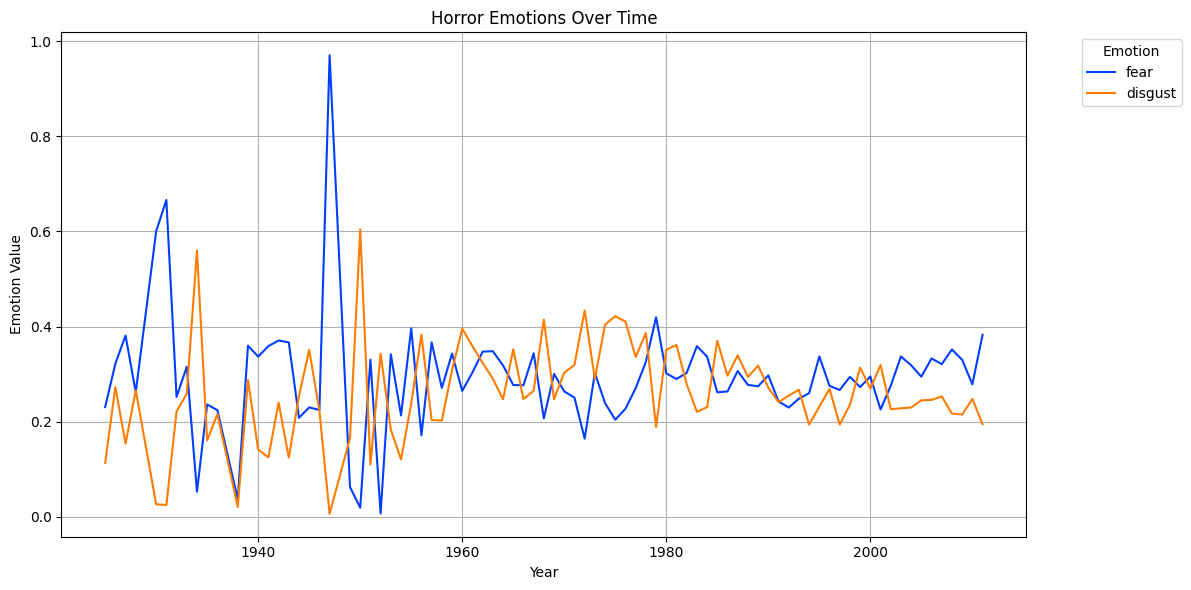

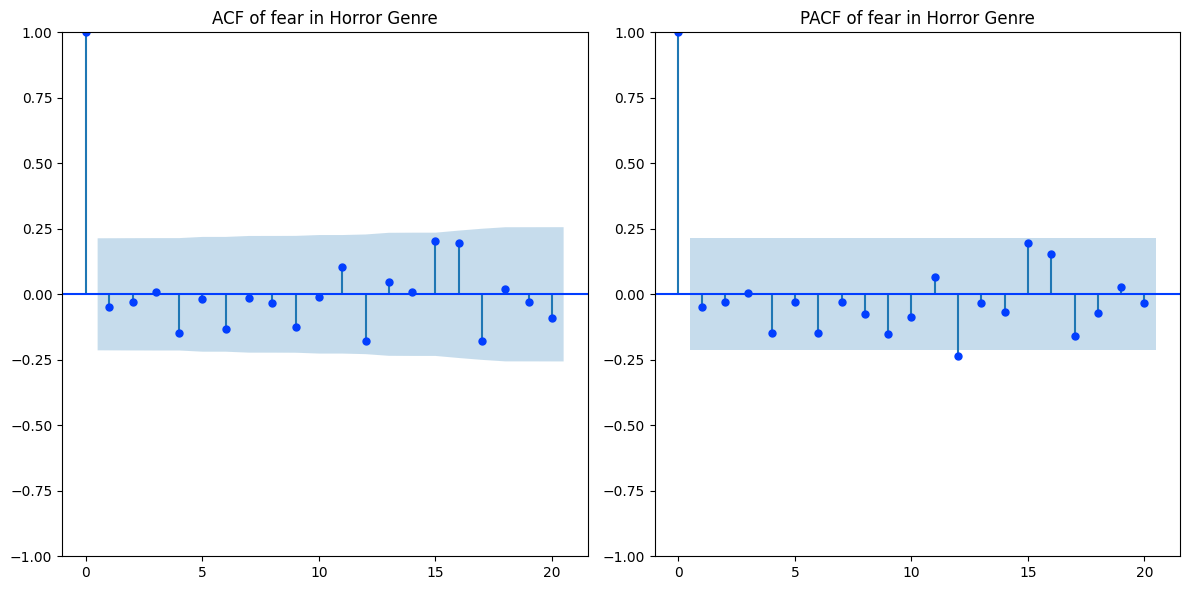

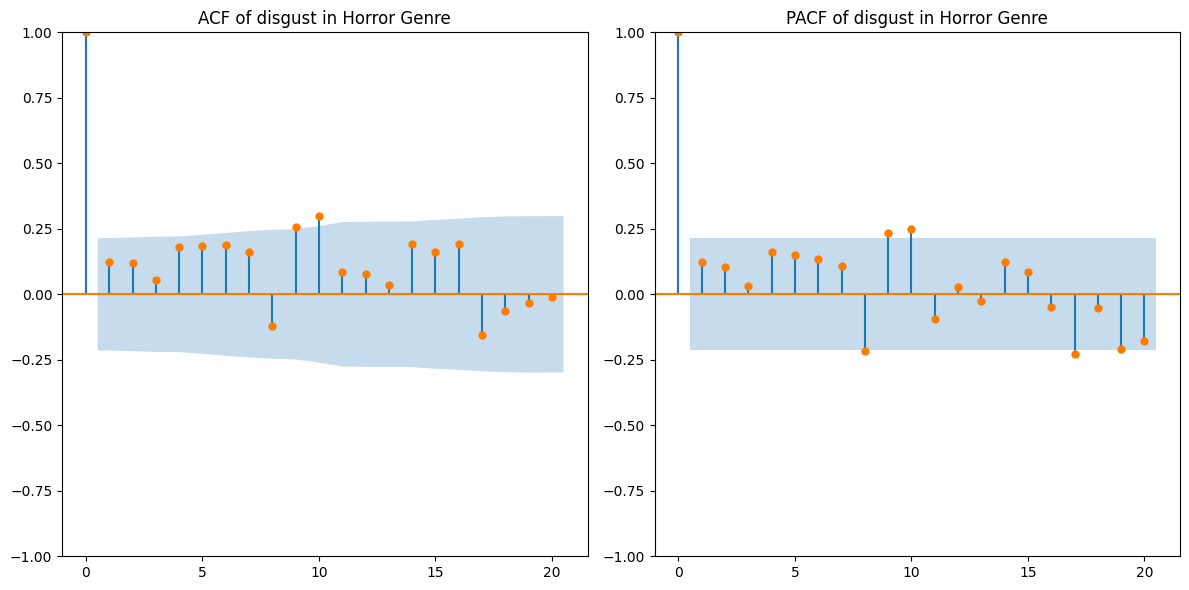

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.428222500318697
p-value: 5.275646181909527e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -1.0727583574924526
p-value: 0.725812418760936
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 1)


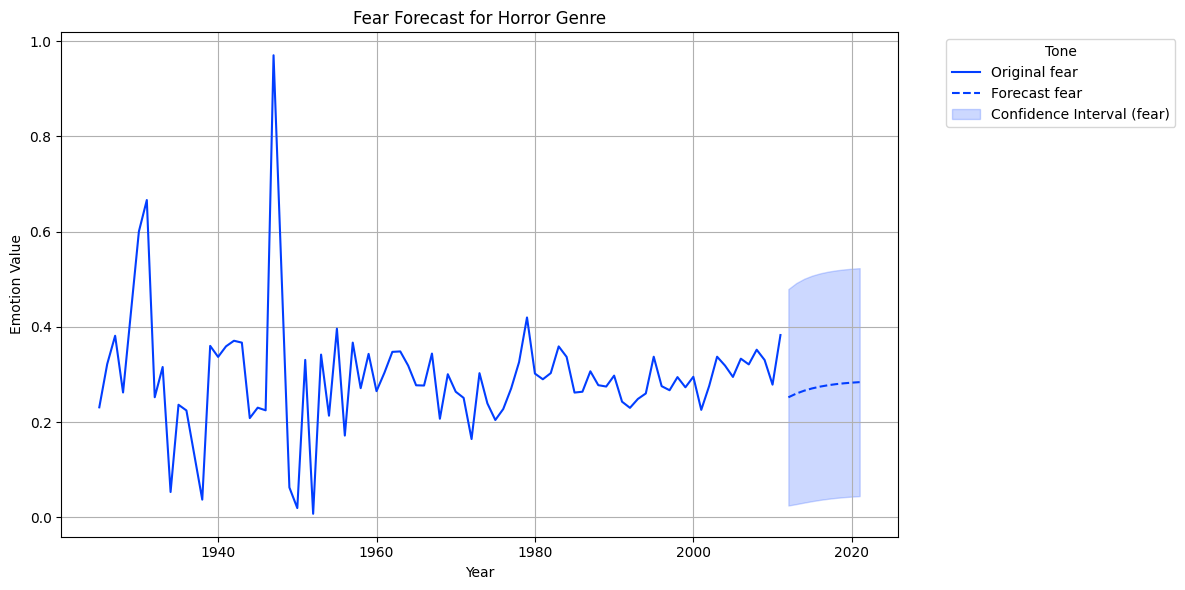

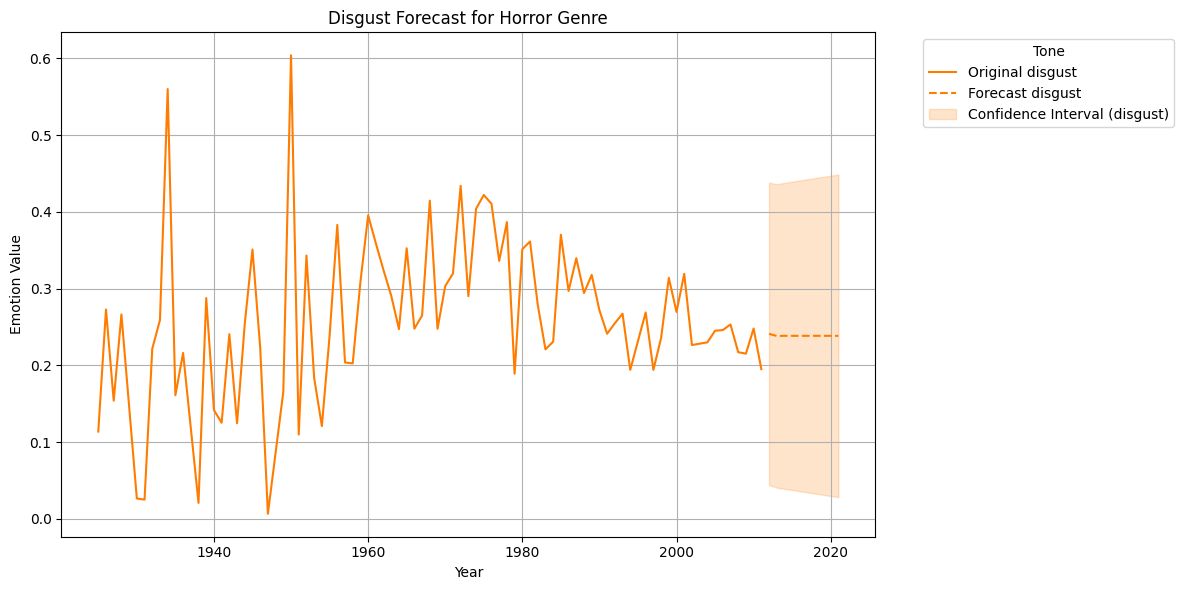

In [10]:
timeseries_plots(horror_df, "Horror")
horror_ts_results = box_jenkins_procedure(horror_df, "Horror")
horror_forecast_df = forecast_series(horror_df, "Horror", horror_ts_results)

## Indie movies Time Series Analysis 

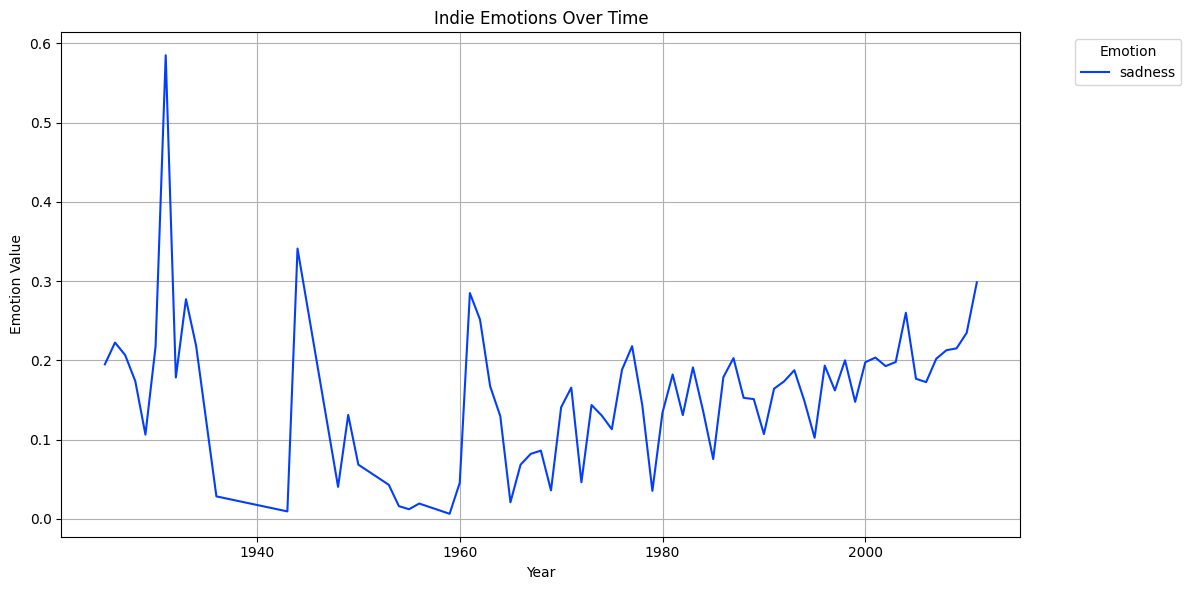

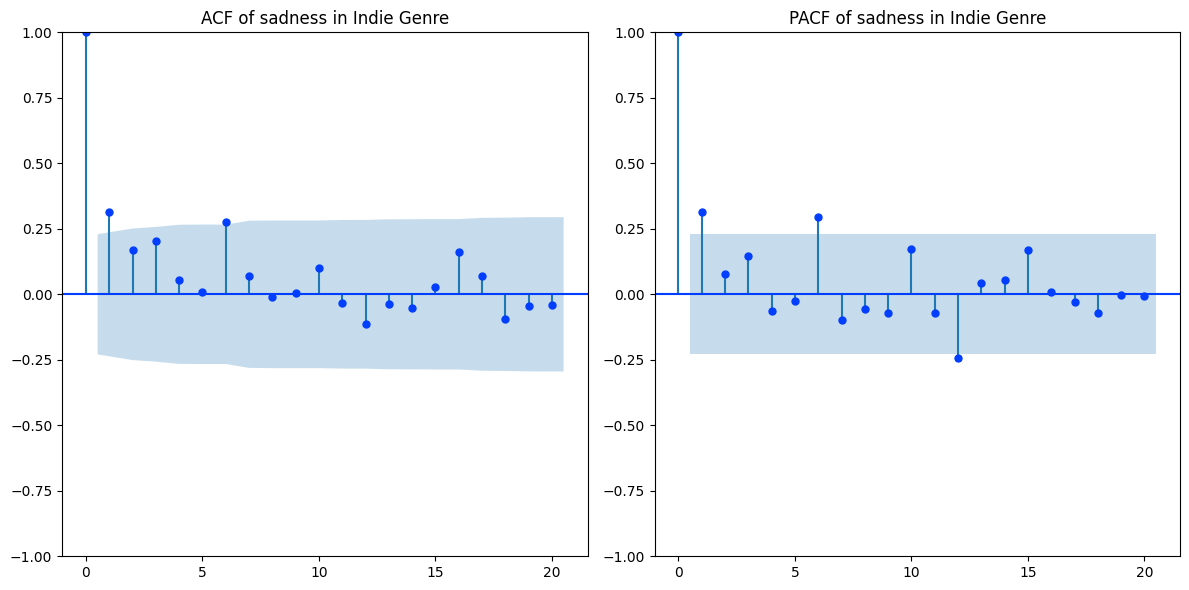

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.290242861905462
p-value: 0.0004618156031471543
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


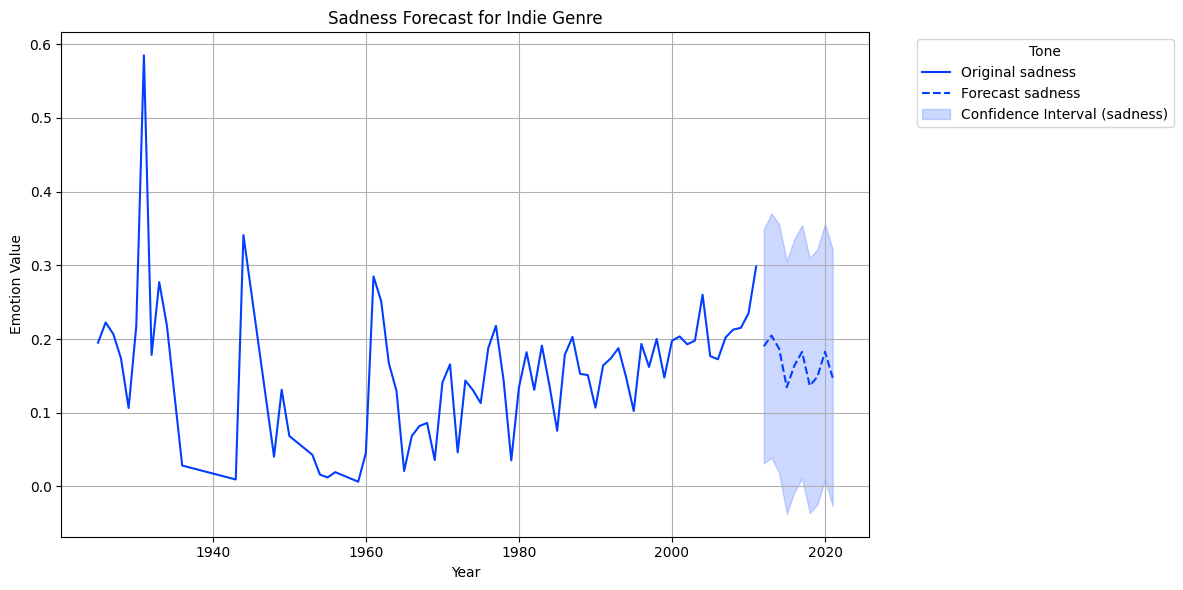

In [11]:
timeseries_plots(indie_df, "Indie")
indie_ts_results = box_jenkins_procedure(indie_df, "Indie")
indie_forecast_df = forecast_series(indie_df, "Indie", indie_ts_results)

## Romance movies Time Series Analysis 

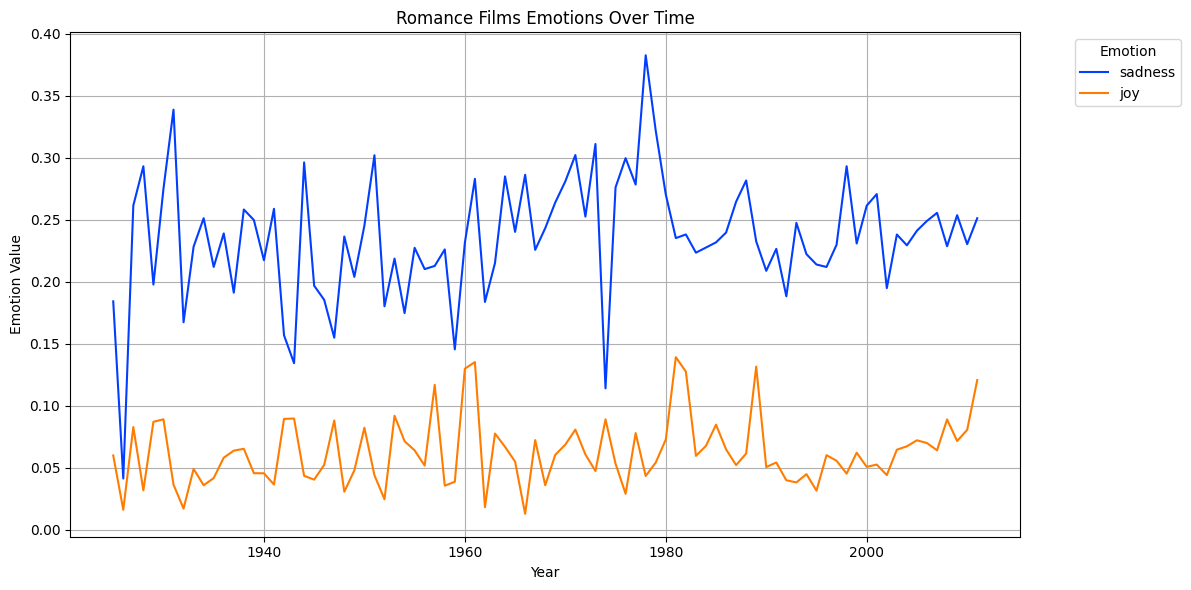

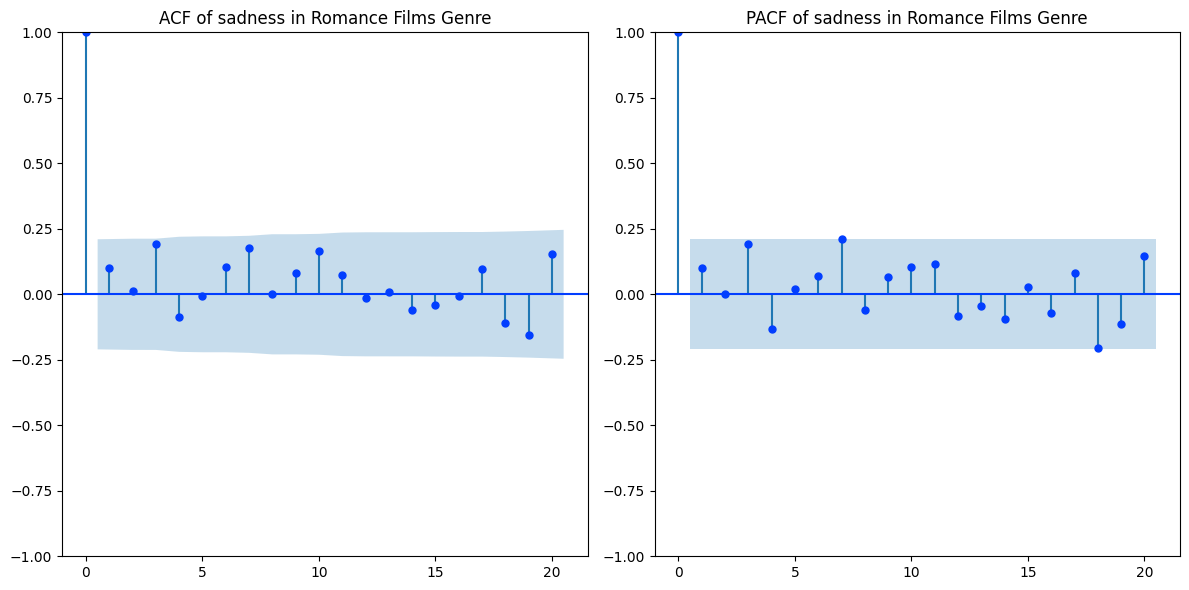

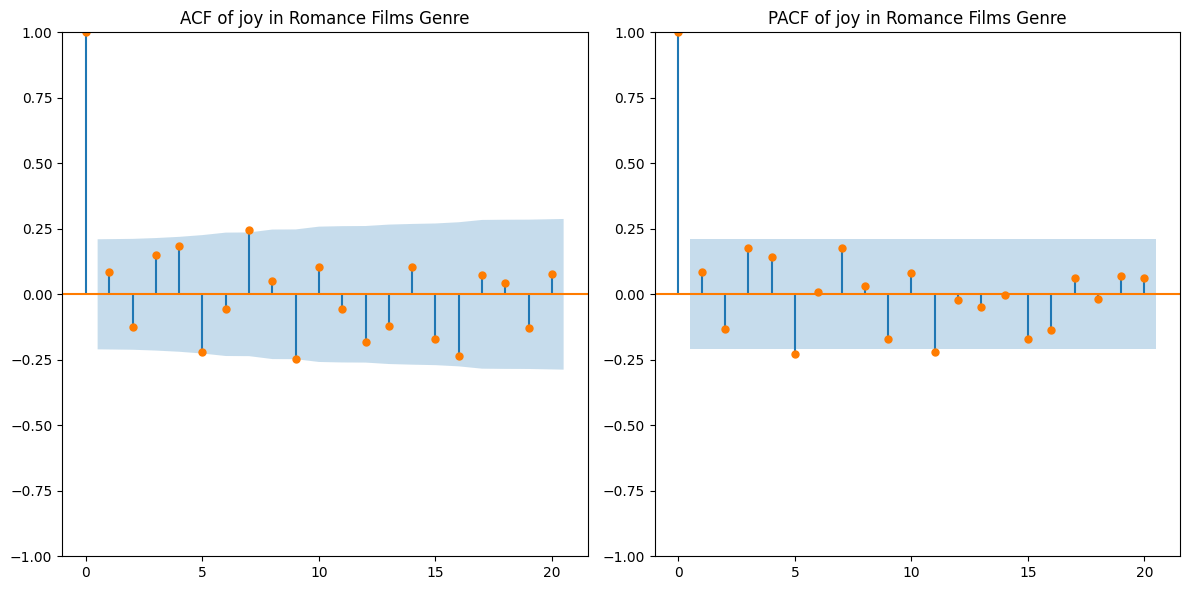

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -8.329339184936082
p-value: 3.40190210480034e-13
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.864368224350091
p-value: 0.04965115747924053
Best ARIMA Order for joy in Romance Film Genre: (2, 0, 2)


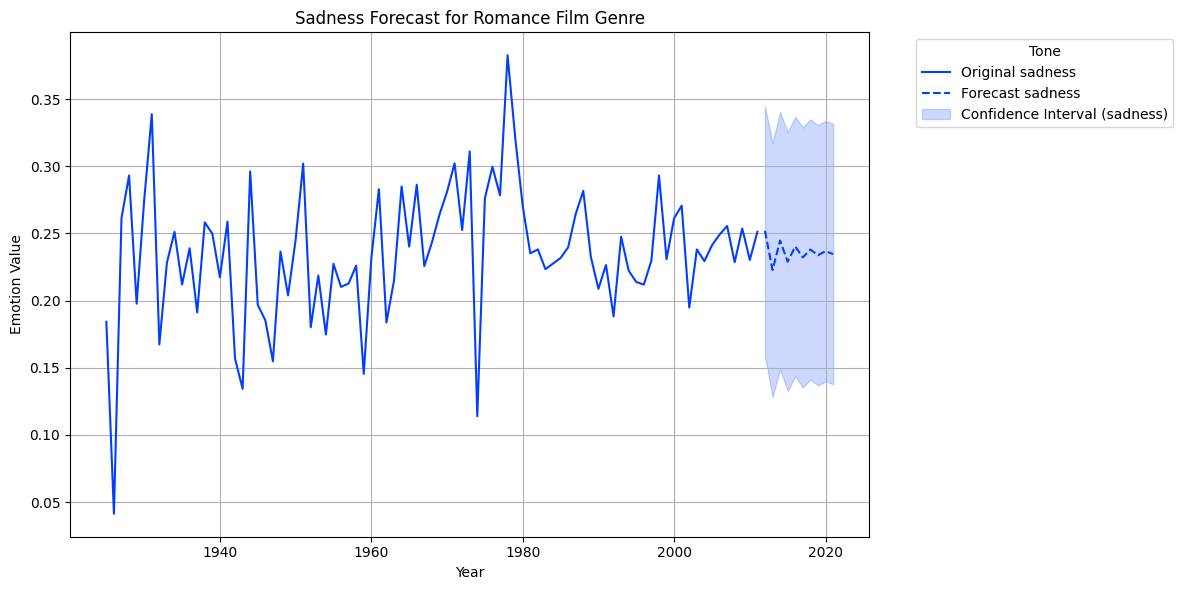

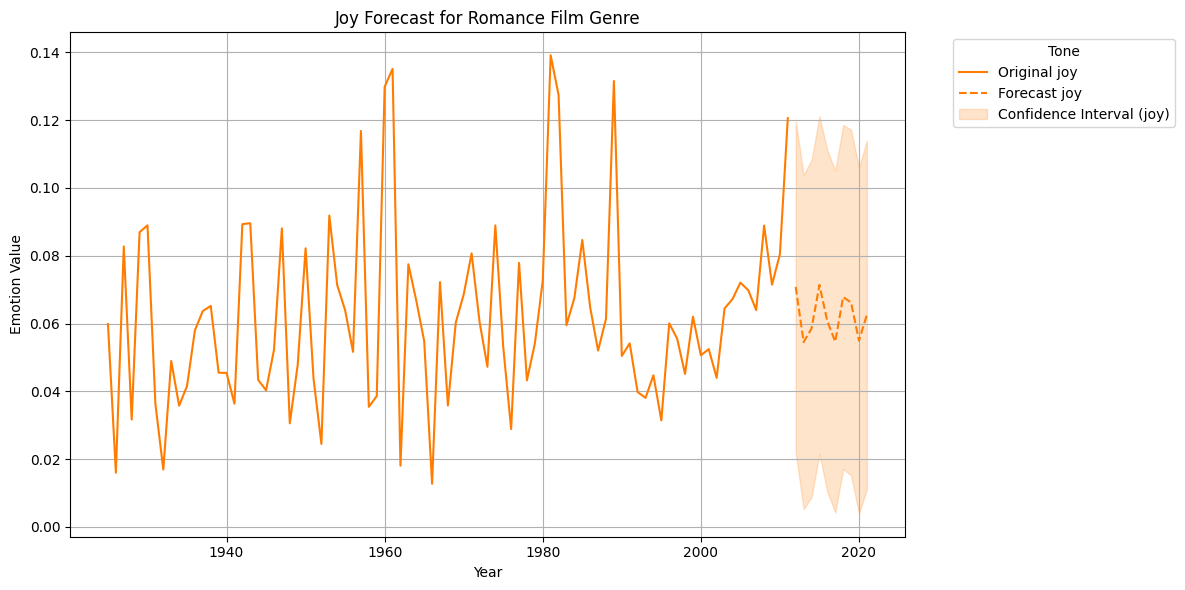

In [12]:
timeseries_plots(romance_film_df, "Romance Films")
romance_ts_results = box_jenkins_procedure(romance_film_df, "Romance Film")
romance_forecast_df = forecast_series(romance_film_df, "Romance Film", romance_ts_results)

## Thriller movies Time Series Analysis

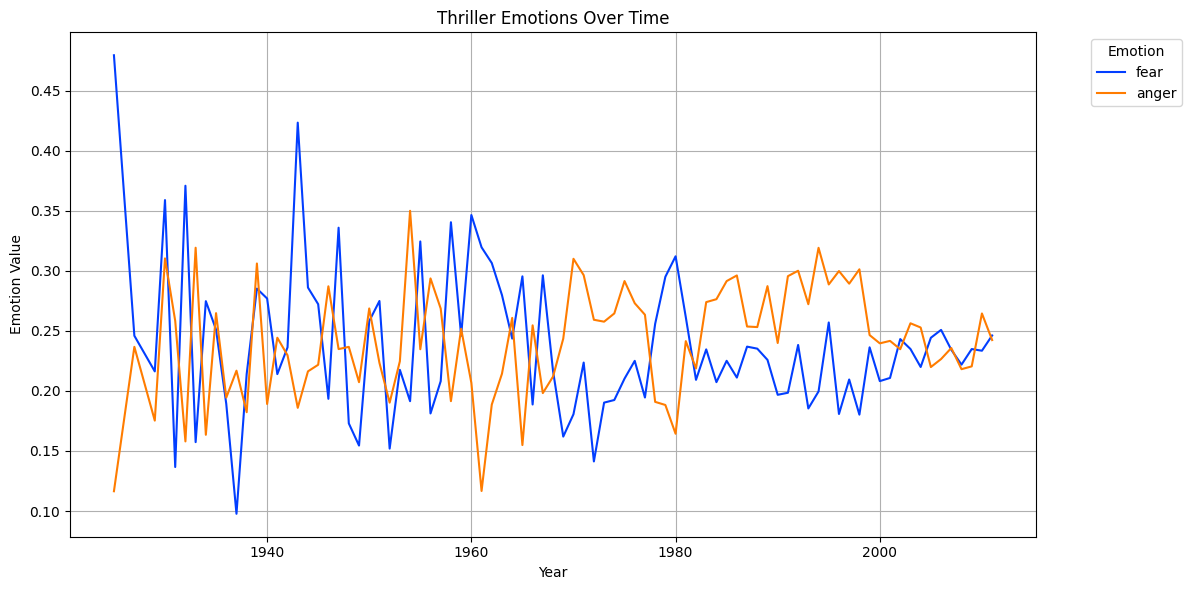

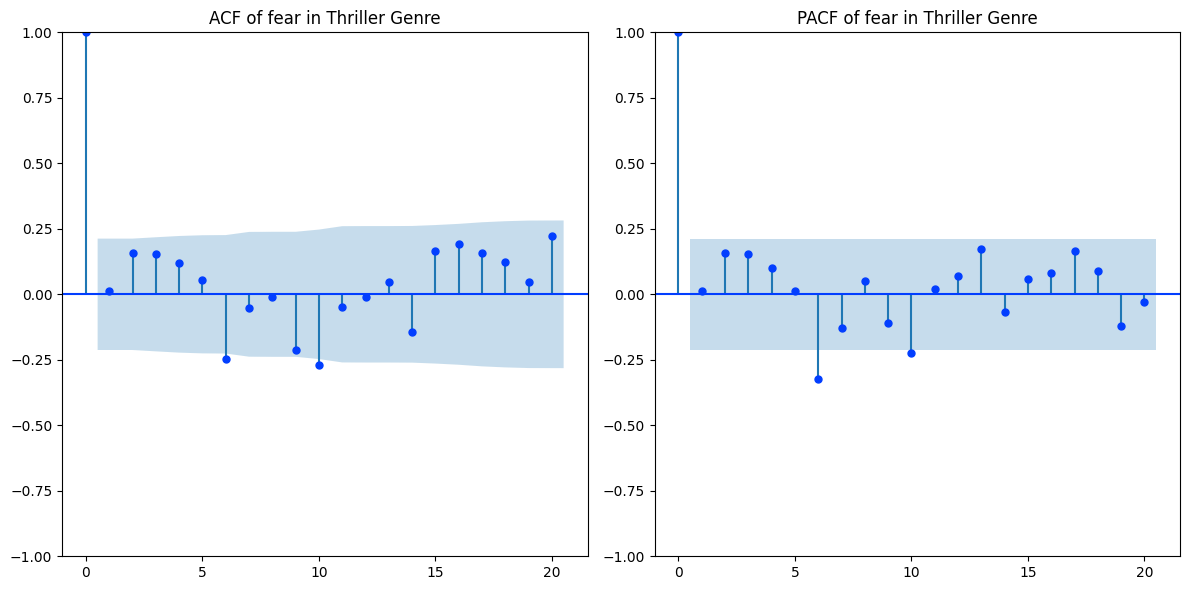

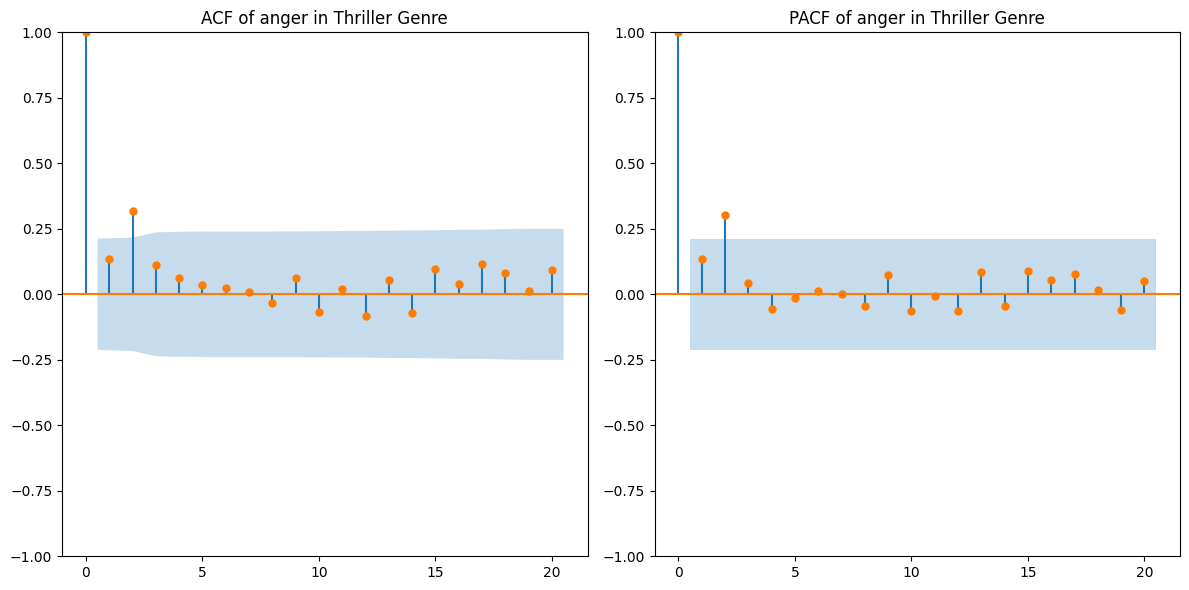

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.380649133353828
p-value: 0.00032113466060936234
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.398199262173894
p-value: 0.00029901836591139967
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


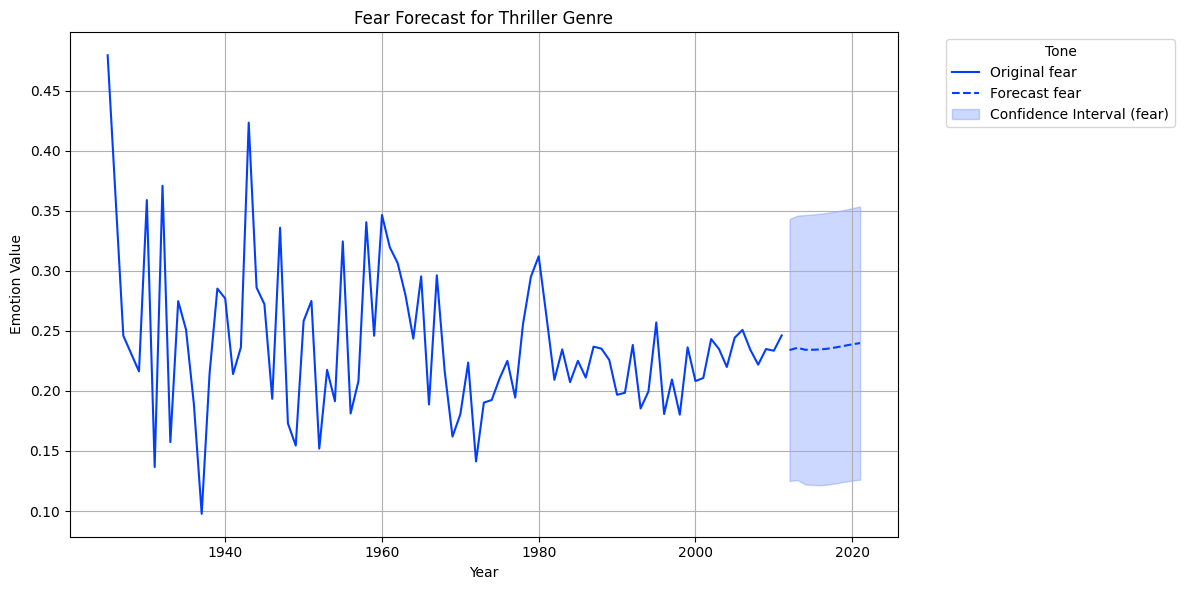

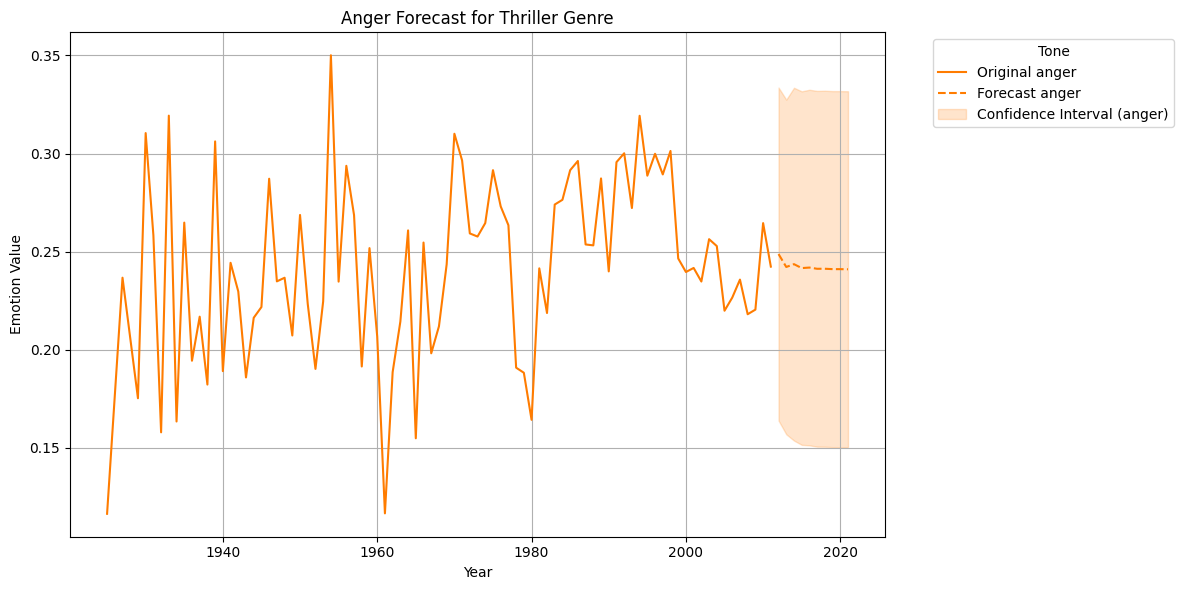

In [63]:
timeseries_plots(thriller_df, "Thriller")
thriller_ts_results = box_jenkins_procedure(thriller_df, "Thriller")
thriller_forecast_df = forecast_series(thriller_df, "Thriller", thriller_ts_results)

## World Cinema movies Time Series Analysis

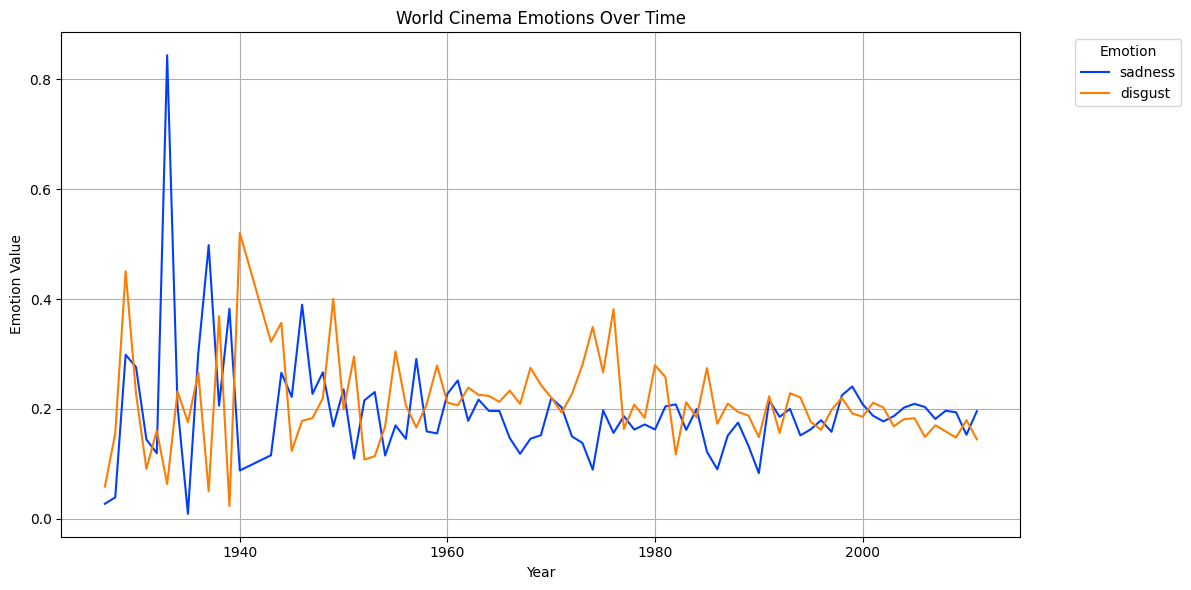

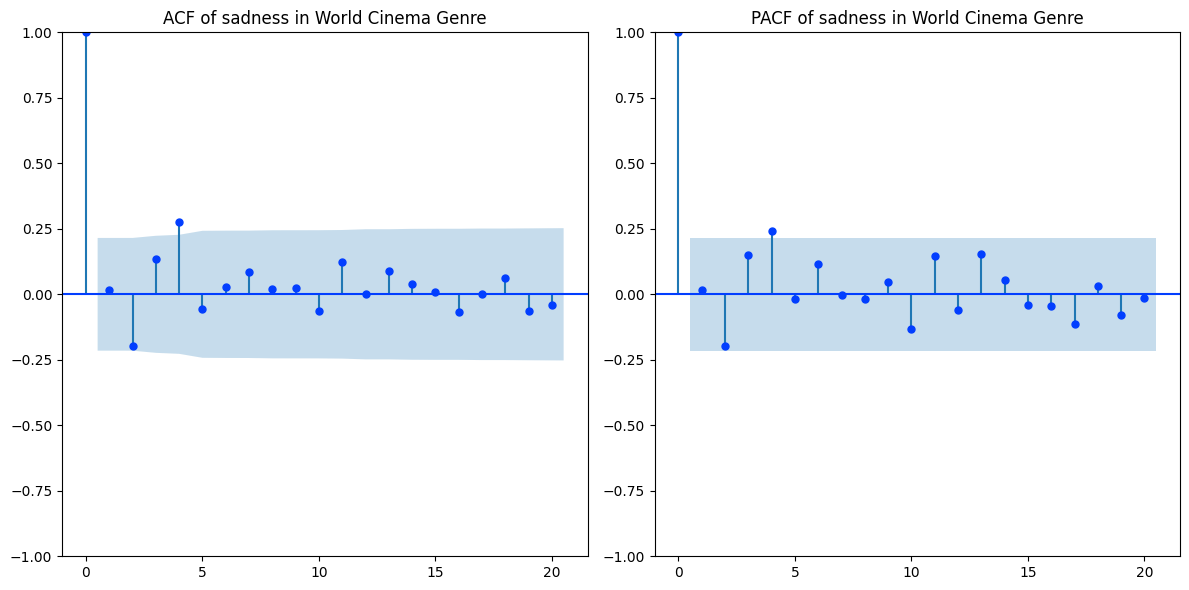

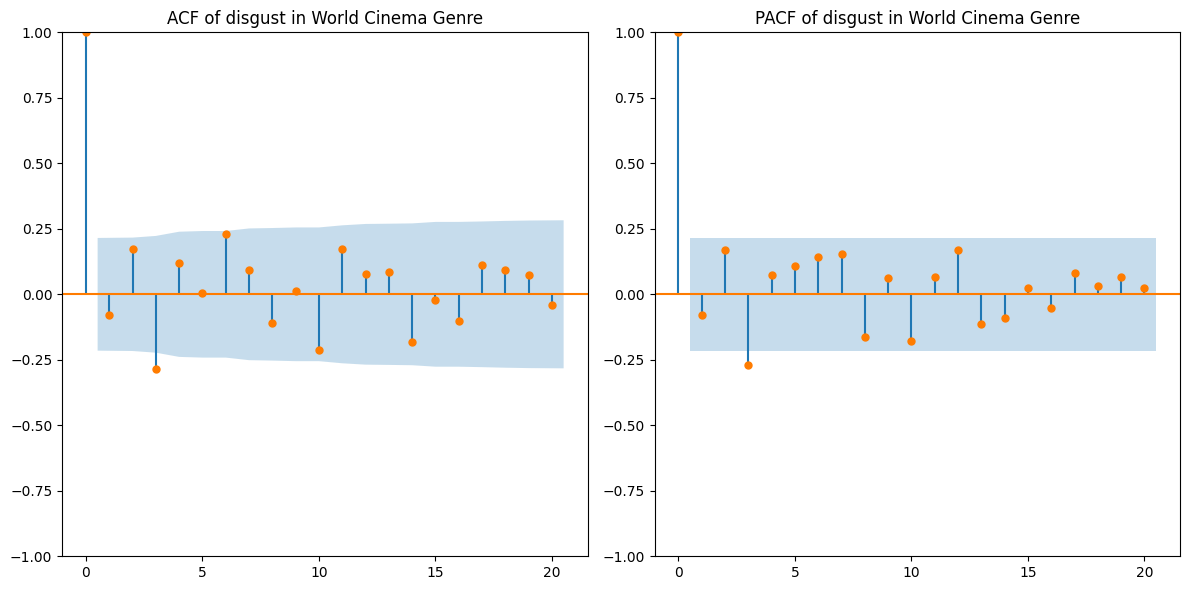

##########################################
 Performing Box-Jenkins Procedure for sadness in World Cinema Genre
ADF Statistic: -3.6754907309791083
p-value: 0.004471408710045471
Best ARIMA Order for sadness in World Cinema Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in World Cinema Genre
ADF Statistic: -5.958683939337718
p-value: 2.0637716996936205e-07
Best ARIMA Order for disgust in World Cinema Genre: (3, 0, 0)


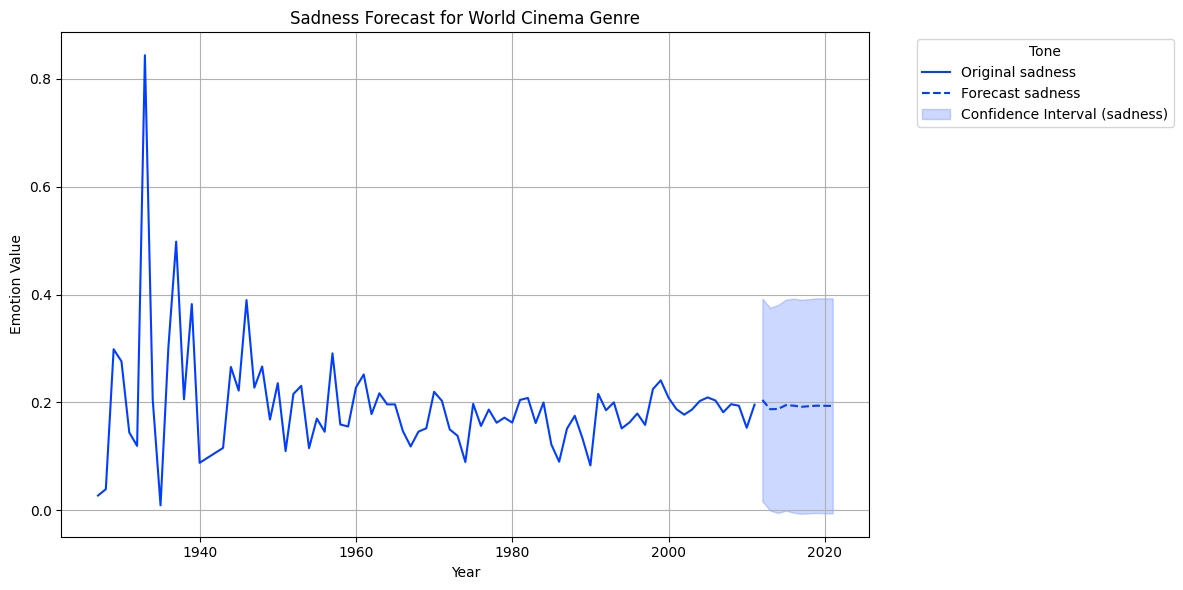

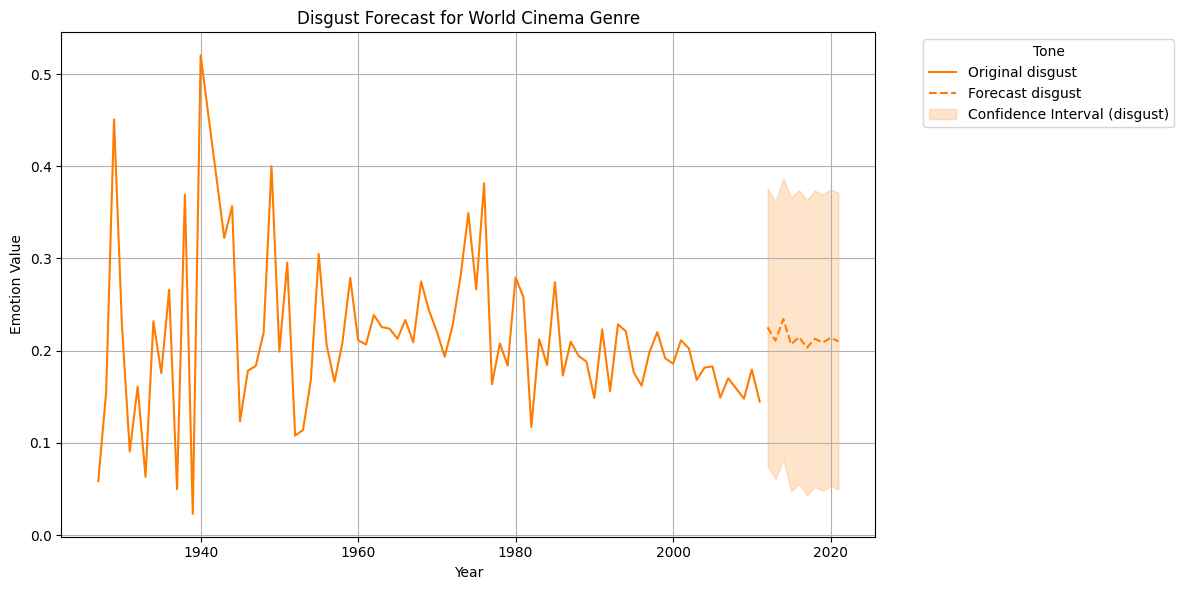

In [13]:
timeseries_plots(world_cinema_df, "World Cinema")
world_ts_results = box_jenkins_procedure(world_cinema_df, "World Cinema")
world_forecast_df = forecast_series(world_cinema_df, "World Cinema", world_ts_results)